# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Цель выполнения работы: провести анализ рынка недвижимости по полученным данным.

План выполнения работы:
1) Общая предобработка данных
* Изменить тип данных столбцов где это нужно
* Удалить явные дубликаты

2) Обработка и анализ данных
* Проанализировать причины пропусков
* Заполнить пропуски, там где это возможно
* Убрать аномальные значения и сравнить полученные результаты
* Проверка синтетических данных на достоверность

3) Добавление новых столбцов в датафрейм

4) Проведение исследовательского анализа данных
* Анализ времени продажи объявлений
* Анализ удаленности от парков и центра
* Группировка этажности квартир

5) Задание как быстро продавались квартиры
* Ответ на вопрос какие квартиры продавались долго, а какие быстро

6) Определить факторы влияющие на цену квартиры
* Построение корреляционной матрицы
* Анализ полученных графиков
* Ответ на вопрос, какие факторы наиболее влияют на цену квартиры

7) Общий вывод по проделанной работе

### Откройте файл с данными и изучите общую информацию

In [329]:
import pandas as pd
import matplotlib.pyplot as plt

In [330]:
# check

try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df = pd.read_csv('real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Видно что некоторые данные имеют неподходящие типы данных, а также пропуски

In [332]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Имеются пропуски. Скорее всего пропуски в "is_apartment", "balcony" являются неправильным заполнением данных.
Также постараемся заполнить "ceiling_height", "living_area", "kitchen_area" синтетическими данными и потом проверим на их корректность.
Остальные пропуски оставим без изменений

Видно что в данных имеются пропуски, нужно узнать их причину и заполнить где это возможно

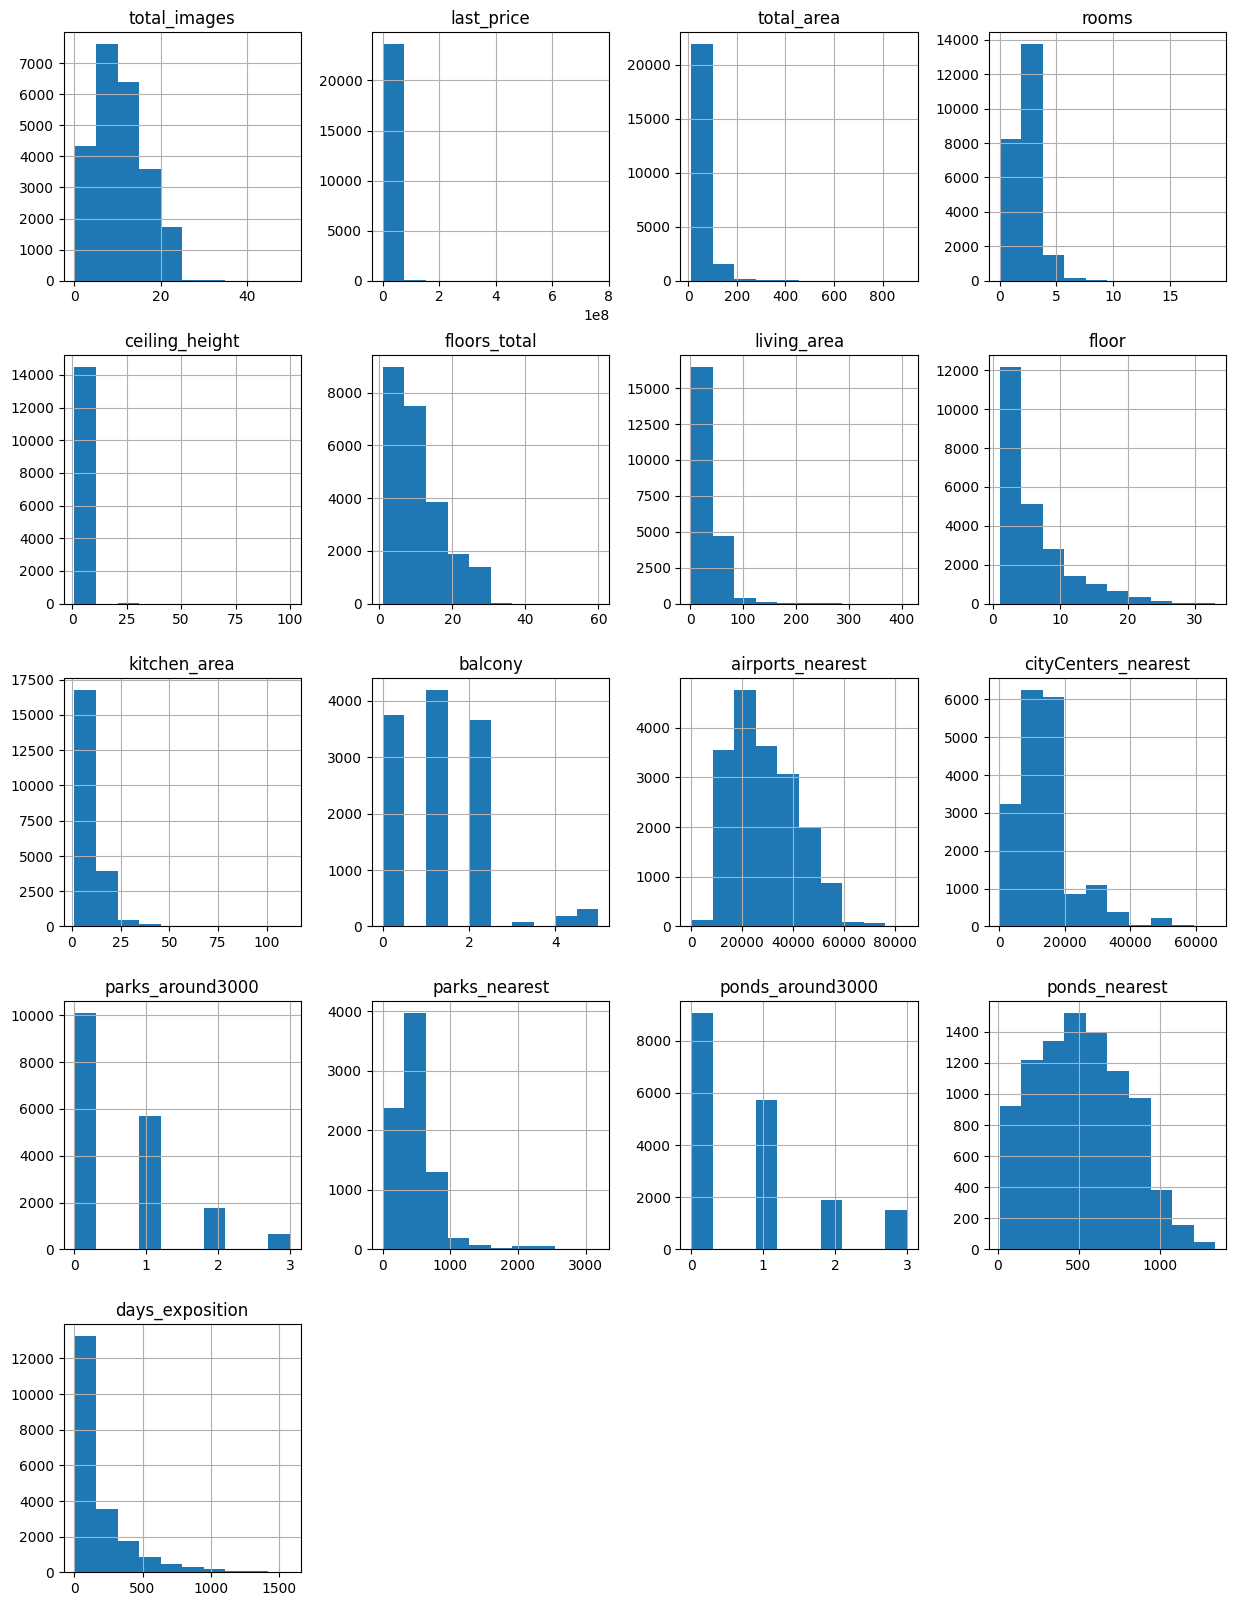

In [333]:
df.hist(figsize=(15, 20))
plt.show()

Бегло осмотрим распрделения данных из датафрейма, сделаем первичные выводы. Так во многих столбцах можно увидеть экстримально высокие или низкие значения, например в столбце 'ceiling_height', где высота потолка могла достигать 100 метров или быть близкой к 0. Нужно проверить данные на наличие экстремальных значений, пропусков, которые могли бы исказить распределения данных.

### Общая предобработка данных

Выполним предобработку данных. Проверим датафрейм на наличие явных дубликатов и прогоним через фильтр.
Изменим неявные дубликаты в столбце "locality_name"

In [334]:

# убираем из названия мест лишние обозначения
# p.s так и не понял почему первые 4 значения идут с пробелом

df.locality_name = (df.locality_name.str.replace('ё', 'е')
                    .replace(['городской поселок ','деревня ',
                              'коттеджный поселок', 'поселок ',
                              'садоводческое некоммерческое товарищество', 'село ',
                              'садовое товарищество ', 'поселок городского типа ',
                              'при железнодорожной станции ', 'поселок станции ',
                              'городского типа ', 'имени ', 'станции '], '', regex=True)).str.strip()

# проверяем измененные значения
print(sorted(df.locality_name.unique().astype('str')))
# убираем значения квартир без места
df.dropna(subset=['locality_name'],inplace=True)
df.reset_index(drop=True,inplace=True)
# проверим нет ли пропущенных значений
df.locality_name.isna().sum()

['nan', 'Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро', 'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров', 'Бокситогорск', 'Большая Вруда', 'Большая Ижора', 'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино', 'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь', 'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево', 'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово', 'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг', 'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово', 'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево', 'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово', 'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка', 'Елизаветино', 'Ефимовский', 'Жилгородок', 'Жилпоселок', 'Житково', 'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск', 'Зимитицы', 'Ивангород', 'Извара', 'Ильичево', 'Иссад', 'Калитино', 'Каложицы', 'Кальтино', 'Каменногорск', 'Камышовка', 'Каськово

0

#### Предобработка данных

In [335]:
# check
df.locality_name.nunique()

305

In [336]:
df_duplicates_rows = df.duplicated(['total_area', 'floor', 'floors_total',
                                  'rooms', 'cityCenters_nearest', 'locality_name'])
df_duplicates_rows.sum()

209

Нашли явные дубликаты по выбранным параментрам, уберем их и сбросим индекс

In [337]:
df = df.drop(df[df_duplicates_rows].index).reset_index(drop=True)

In [338]:
total_area_filter = df.total_area*0.9 <= (df.living_area + df.kitchen_area)
total_area_filter.value_counts()

False    22972
True       469
Name: count, dtype: int64

In [339]:
df = df.drop(df[total_area_filter].index).reset_index(drop=True)
total_area_filter = df.total_area*0.9 <= (df.living_area + df.kitchen_area)
total_area_filter.value_counts()

False    22972
Name: count, dtype: int64

В данном блоке мы убрали явные дубликаты по параметрам:
* общ. площадь квартиры
* этаж
* общая этажность дома
* расстояние до центра
* название населенного пункта
* кол-во комнат

Так же мы убрали неявные дубликаты у мест. Вспомогательные слова по типу: "деревня", "поселок", "село" только запутывали, так как люди могли написать название места как с помощью этих слов, так и без них, поэтому от них нужно отказаться.

#### Изменение типа данных

In [340]:
# Изменим тип данных в "first_day_exposition" на date_time
df.first_day_exposition = pd.to_datetime(df.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')

In [341]:
#df['year_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).year
#df.groupby('year_exposition').last_price.median().plot(figsize=(8,5))
#plt.show()
#df.groupby('year_exposition').last_price.median()

In [342]:
# Заменим Nan значения на 0,
# так как скорее всего балкон в таких квартирах отсутсвует
df.balcony.fillna(0, inplace=True)
df.balcony = df.balcony.astype('int64')
df.balcony.isna().sum()

C:\Users\Admin\AppData\Local\Temp\ipykernel_24968\397113855.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.balcony.fillna(0, inplace=True)


0

In [343]:
# Заменим пропущенные значения nan в столбике "is_appartment" на 0
display(df.is_apartment.unique())
df.is_apartment.fillna(False, inplace=True)
display(df.is_apartment.value_counts())
df.is_apartment = df.is_apartment.astype('bool')
display(df.is_apartment.value_counts())
df.is_apartment.dtype

array([nan, False, True], dtype=object)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24968\3957197159.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.is_apartment.fillna(False, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24968\3957197159.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.is_apartment.fillna(False, inplace=True

is_apartment
False    22926
True        46
Name: count, dtype: int64

is_apartment
False    22926
True        46
Name: count, dtype: int64

dtype('bool')

In [344]:
df.last_price = df.last_price.astype('int64')

#### Таблица №1

In [345]:
(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,972.00","22,972.00","14,076.00","19,909.00","22,972.00","21,102.00","20,731.00","22,972.00","22,888.00"
min,0.00,12.00,1.00,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,32.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00
median,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.10,4.00,9.00


Видно что в данных имеются пропуски и экстримально минимальные и максимальные значения. Попытаемся заполнить пропуски и дать объяснения вбросам.

#### Таблица №2 

In [346]:

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,0.00,20.00,2.34,3.00,"562,826.00",10.00,3.98,1.00,2.00
0.010000,1.00,25.50,2.50,4.00,"1,050,000.00",13.00,5.00,1.00,2.00
0.500000,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.10,4.00,9.00
0.990000,5.00,196.29,3.80,"1,069.92","35,499,290.00",117.00,35.00,23.00,26.00
0.998800,8.00,387.83,24.11,"1,368.55","124,706,096.00",214.39,55.52,26.00,34.54


Рассмотрим квантили, чтобы понять какие значения присвоены большей части данных в каждом столбце

#### Обработка и анализ данных

##### Анализ ceiling_height

In [347]:
df.ceiling_height.describe()

count    14076.000000
mean         2.760926
std          0.937248
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

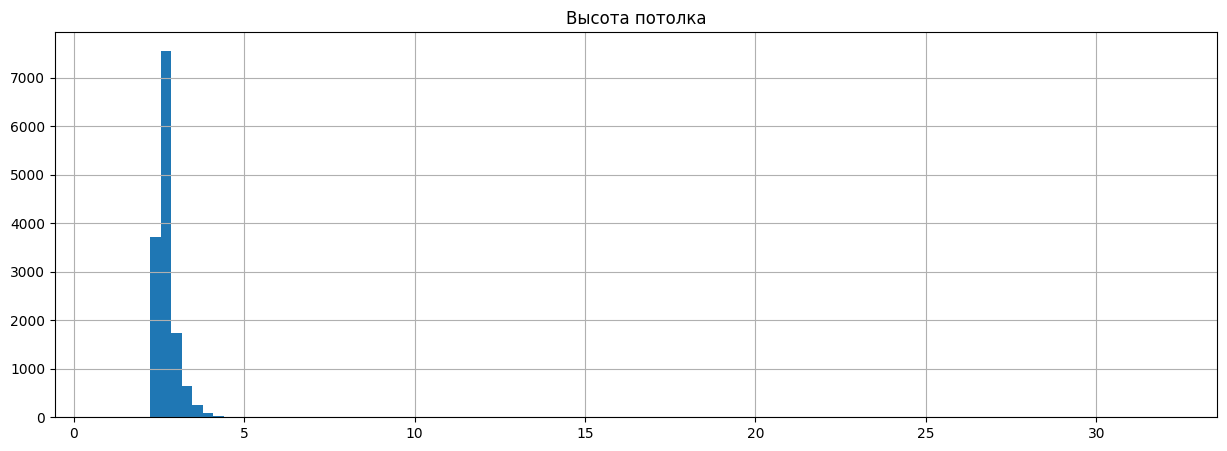

In [348]:
df.ceiling_height.hist(bins=100, figsize=(15,5))
plt.title('Высота потолка')
plt.show()

Разберем значения в столбце "ceiling_height", в нем имеются как и явные выбросы длина потолков 1 метр или 100 метров, а также и явные пропуски, которые можно будет заполнить медианным значением. Заметим из таблицы №2 что 99.88% значений лежат до длины потолка 8 метров, однако люди при письменом заполнений могли ошибиться на 1 десяток, поэтому для экстримальных значений введем проверку на некорректность написания

Рассмотрим пиковые значения в от 2 до 4 метов ближе

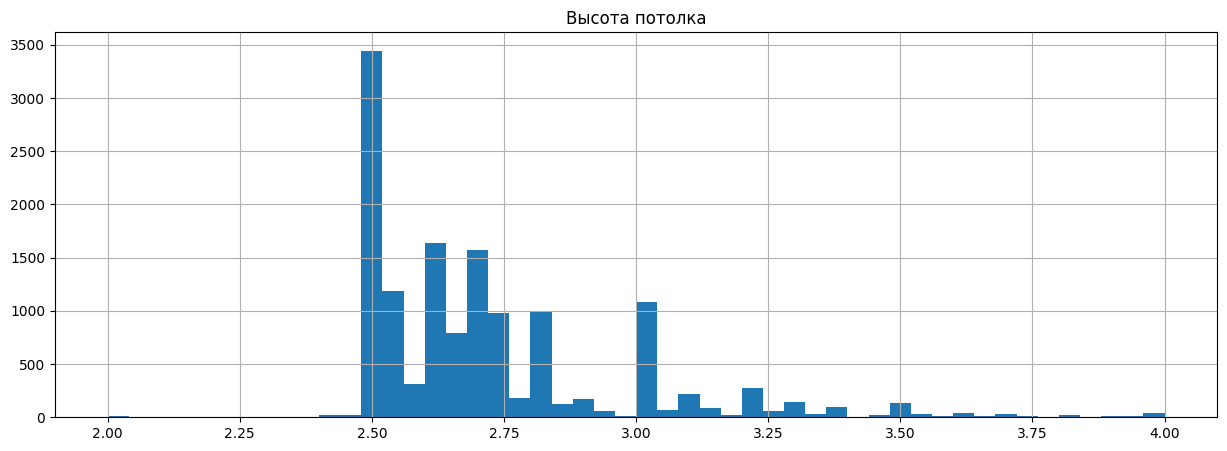

In [349]:
df.ceiling_height.hist(bins=50, range=(2,4), figsize=(15,5))
plt.title('Высота потолка')
plt.show()

Наиболее популярным значением среди потолков является 2.5 метра. Так как у нас присутствуют пропуски в данных, величина может измениться

'Минимальное значение потолка'

2.25

'Максимальное значение потолка'

32.0

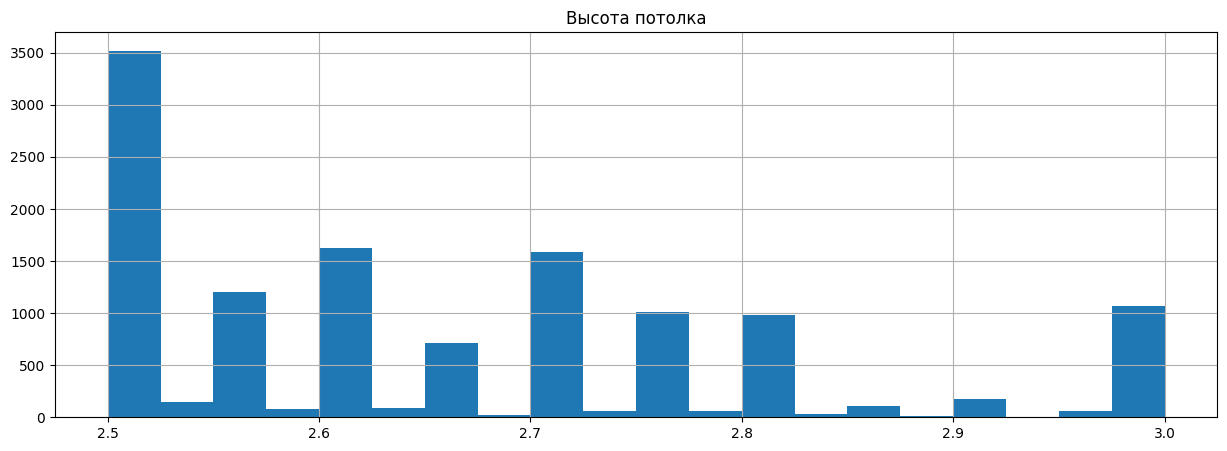

In [350]:
# Приведем высоту потолка к нормальным значениям, аномалии уберем, за минимальное значение возьмем потолок 2 метра
df.ceiling_height = df.ceiling_height.drop(df.query('ceiling_height <= 2').index).reset_index(drop=True)
display('Минимальное значение потолка', df.ceiling_height.min(), "Максимальное значение потолка",df.ceiling_height.max())
# сделаем проверку  на ошибку данных при заполнении пользователем возьмем длину 20 метров,
# чтобы при делении на 10 не вышло меньше 2 метров
df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] = df['ceiling_height'] / 10
df.ceiling_height.hist(bins=20, range=(2.5,3), figsize=(15,5))
plt.title('Высота потолка')
plt.show()

Видим, что дальше 3.5 метров потолки это вбросы, уберем их из анализа

In [351]:
df.ceiling_height = df.loc[df['ceiling_height'] < 3.5, 'ceiling_height']
df.ceiling_height.value_counts()

ceiling_height
2.50    3410
2.60    1612
2.70    1547
3.00    1066
2.55     965
        ... 
3.39       1
3.43       1
2.34       1
3.44       1
3.48       1
Name: count, Length: 109, dtype: int64

In [352]:
df['city_Centers_nearest_km'] = round(df['cityCenters_nearest'] / 1000)
df['city_Centers_nearest_km'].isna().sum()

5237

In [353]:
# заполним пропуски в ceiling_height медианными значениями.
# Также учтем, высота потолков изменяется от удаленности от центра Питера
display(df.ceiling_height.isna().sum())
for km in df['city_Centers_nearest_km'].unique():
    df.loc[(df['locality_name'] == "Санкт-Петербург") & (df['ceiling_height'].isna()) & (df['city_Centers_nearest_km'] == km), 'ceiling_height'] = \
    df.loc[(df['locality_name'] == "Санкт-Петербург") & (df['city_Centers_nearest_km'] == km)].ceiling_height.median()

                                                  
display(df.ceiling_height.isna().sum())

9302

3112

In [354]:
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median()
display(df.ceiling_height.isna().sum())

0

In [355]:
df.ceiling_height = df.loc[df['ceiling_height'] < 3.5, 'ceiling_height']

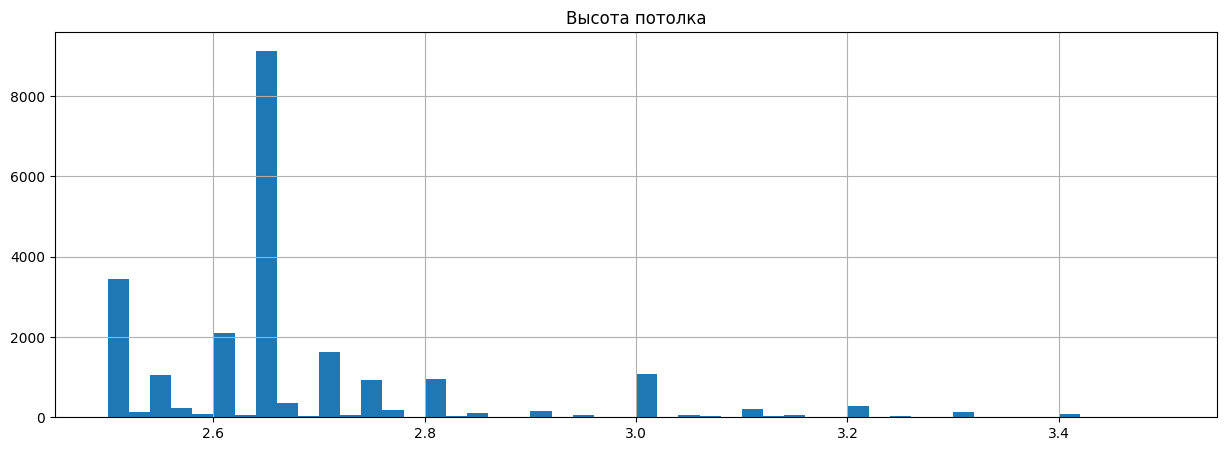

count    22972.000000
mean         2.676198
std          0.163704
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.490000
Name: ceiling_height, dtype: float64

In [356]:
df.ceiling_height.hist(bins=50,range=(2.5, 3.5), figsize=(15,5))
plt.title('Высота потолка')
plt.show()
df.ceiling_height.describe()

In [357]:
df.shape

(22972, 23)

Видим, что самым пиковым значением являются потолки 2.65 метров, также популярными вариантами являются потолки на 2.5, 2.6 метра

In [358]:
df.loc[df['ceiling_height'] == 3].locality_name.value_counts()

locality_name
Санкт-Петербург    720
Парголово           19
Кудрово             19
Мурино              18
Шушары              16
                  ... 
Сосново              1
Яльгелево            1
Большая Вруда        1
Келози               1
Кобралово            1
Name: count, Length: 98, dtype: int64

Большую часть из этих значений представляют собой квартиры из Питера

##### Анализ total_area

In [359]:
df.total_area.describe()

count    22972.000000
mean        60.259831
std         35.561351
min         12.000000
25%         40.000000
50%         52.000000
75%         69.600000
max        900.000000
Name: total_area, dtype: float64

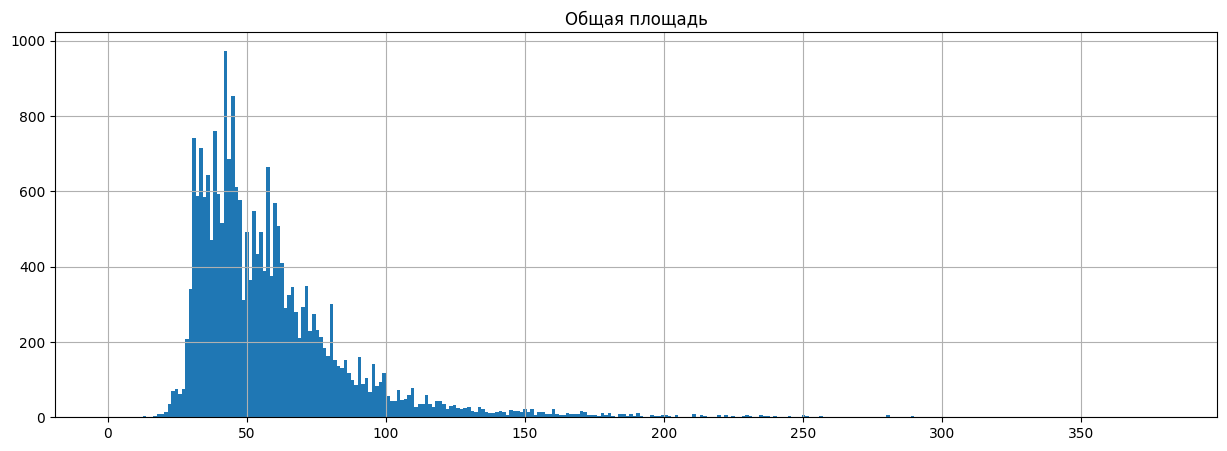

In [360]:
df.total_area.hist(bins=300, range=(0, 380), figsize=(15,5))
plt.title('Общая площадь')
plt.show()

Рассмотрим диапазон меньше 150 кв метров, так как больше является редкостью для наших данных

In [361]:
df = df.drop(df[df['total_area'] > 150].index).reset_index(drop=True)
df.shape

(22435, 23)

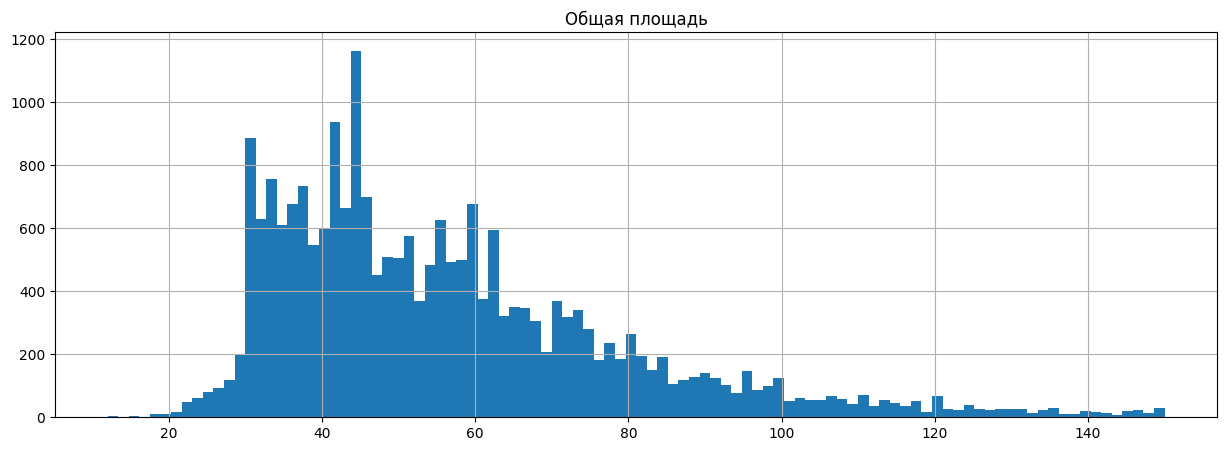

count    22435.000000
mean        56.516486
std         22.888344
min         12.000000
25%         40.000000
50%         51.000000
75%         67.600000
max        150.000000
Name: total_area, dtype: float64

In [362]:
df.total_area.hist(bins=100, figsize=(15,5))
plt.title('Общая площадь')
plt.show()
df.total_area.describe()

В основном квартиры по полощади составяют от 40 до 67 кв метров. Виден пик примерно в районе 43 кв метров. Площади выше 100 кв метра встречаются реже всего

##### Анализ rooms

In [363]:
df.rooms.describe()

count    22435.000000
mean         1.996791
std          0.948946
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

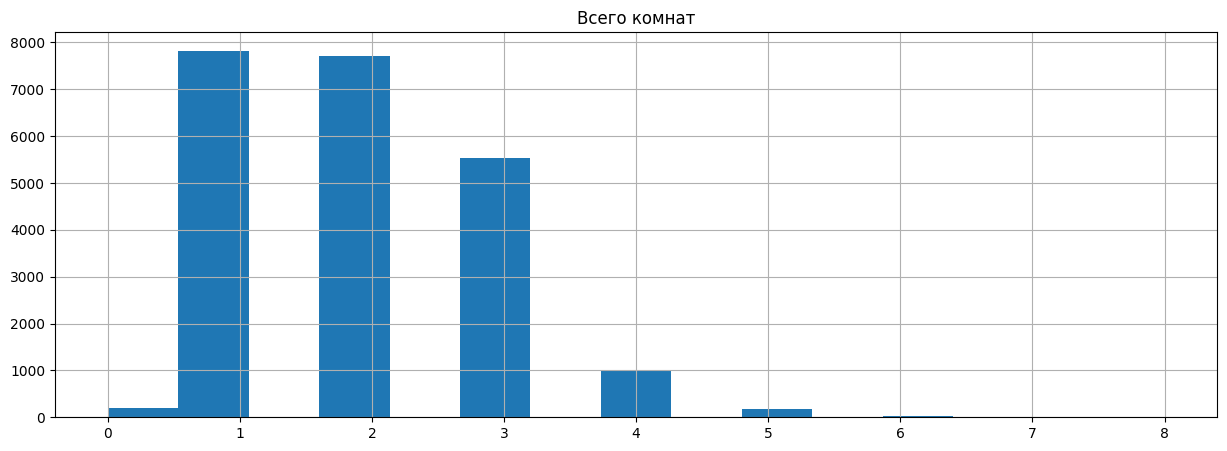

In [364]:
df.rooms.hist(bins=15, figsize=(15,5))
plt.title('Всего комнат')
plt.show()

In [365]:
df = df.drop(df[df['rooms'] > 8].index).reset_index(drop=True)
df.shape

(22435, 23)

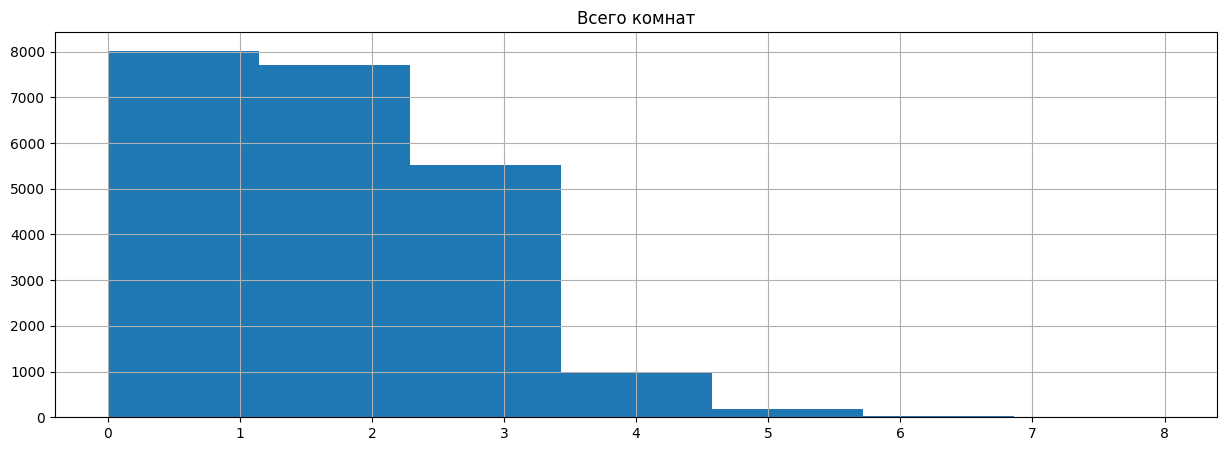

count    22435.000000
mean         1.996791
std          0.948946
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

In [366]:
df.rooms.hist(bins=7, figsize=(15,5))
plt.title('Всего комнат')
plt.show()
df.rooms.describe()

В основном квартиры идут до 3-ех комнат, затем количество квартир с более чем 3-мя комнатами идет на спад. Квартиры с 6, 7, 8 комнатами встречаются редко

##### Анализ floors_total

In [367]:
df.floors_total.describe()

count    22352.000000
mean        10.797691
std          6.612447
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

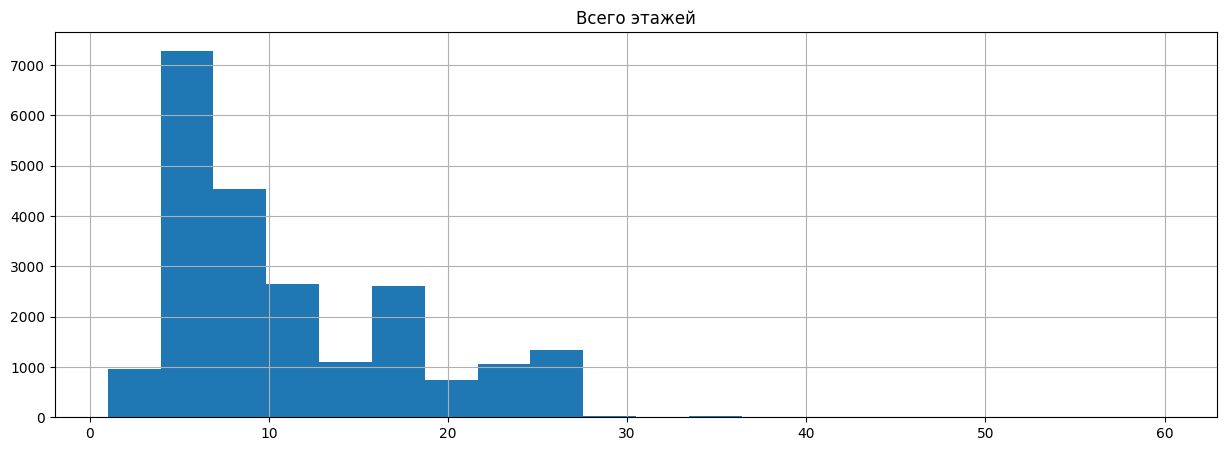

In [368]:
df.floors_total.hist(bins=20, figsize=(15,5))
plt.title('Всего этажей')
plt.show()

Дома с больше чем 27 этажами встречаются редко, уберем их из выборки

In [369]:
df = df.drop(df.loc[df['floors_total'] >= 27].index).reset_index(drop=True)
df.shape

(22223, 23)

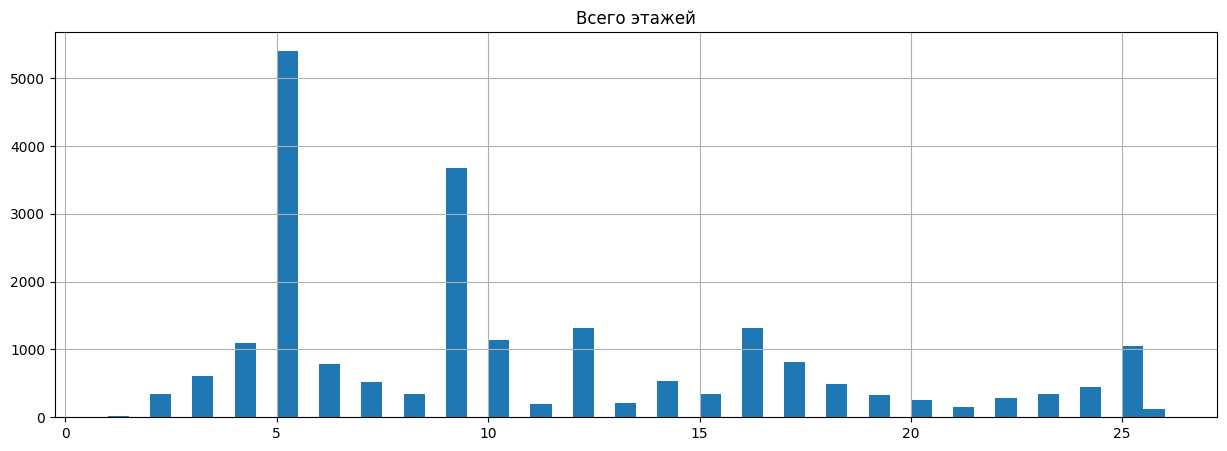

count    22140.000000
mean        10.628681
std          6.402339
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         26.000000
Name: floors_total, dtype: float64

In [370]:
df.floors_total.hist(bins=50, figsize=(15,5))
plt.title('Всего этажей')
plt.show()
df.floors_total.describe()

Пики популярности среди этажности домов приходятся на 5, 9 этажные дома. Остальные менее популярны

##### Анализ floor

In [371]:
df.floor.describe()

count    22223.000000
mean         5.829141
std          4.758937
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         26.000000
Name: floor, dtype: float64

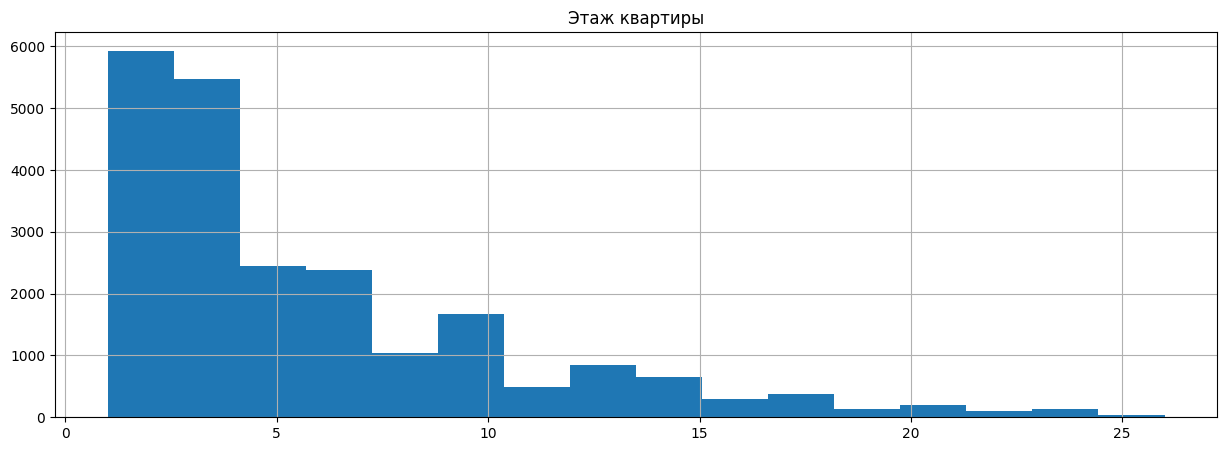

In [372]:
df.floor.hist(bins=16, figsize=(15,5))
plt.title('Этаж квартиры')
plt.show()

In [373]:
df = df.drop(df.loc[df['floor'] > 25].index).reset_index(drop=True)
df.shape

(22218, 23)

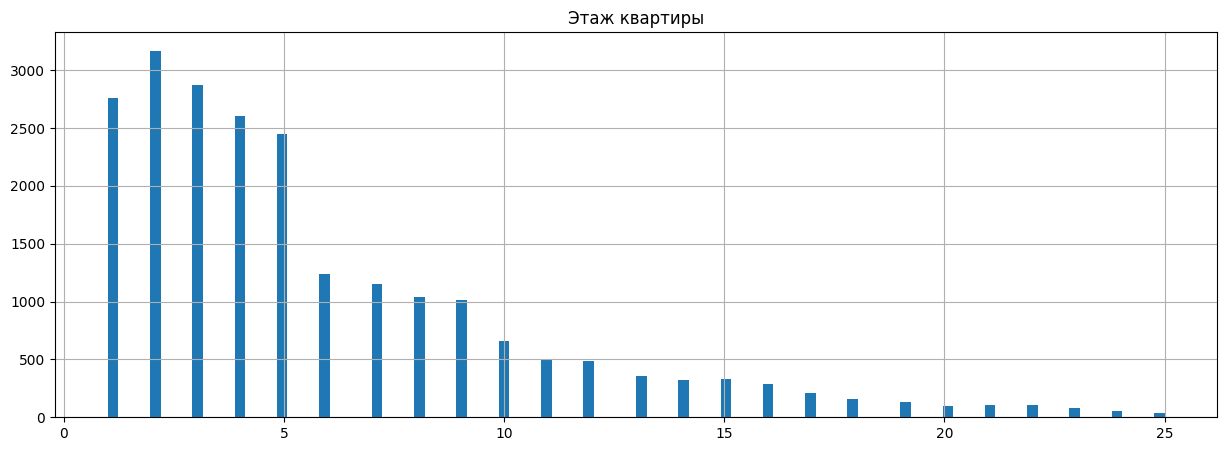

In [374]:
df.floor.hist(bins=100, figsize=(15,5))
plt.title('Этаж квартиры')
plt.show()

Так большая часть квартир расположена с 1 по 5 этажи. Выше 5 ого этажа квартиры представлены реже. Самым популярным является 3ий этаж

##### Анализ last_price

In [375]:
df.last_price.describe()

count    2.221800e+04
mean     5.695440e+06
std      4.478957e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.500000e+06
max      1.240000e+08
Name: last_price, dtype: float64

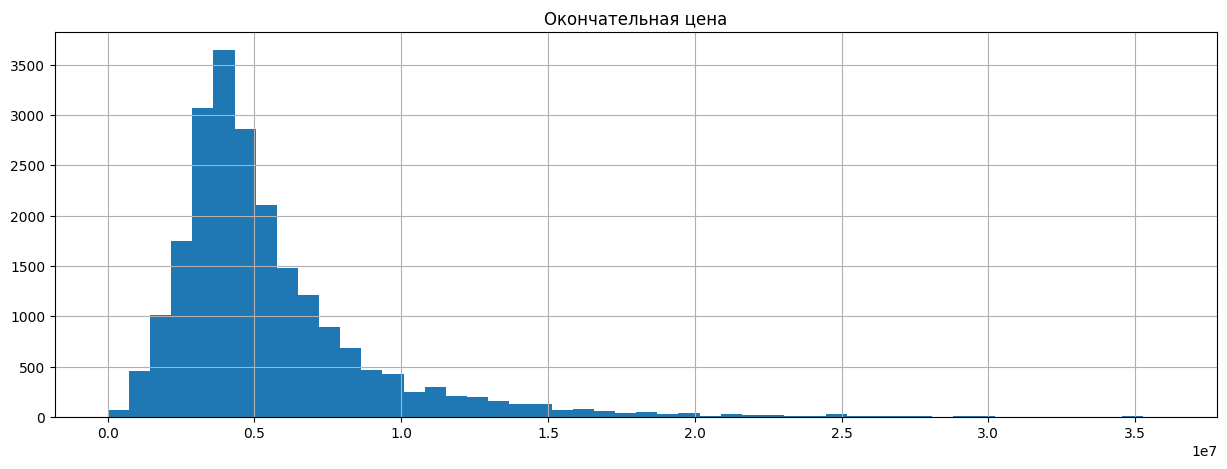

In [376]:
df.last_price.hist(bins=50, range=(0, 3.6e+7), figsize=(15,5))
plt.title('Окончательная цена')
plt.show()

Данные выше 150 млн рублей встречаются редко, уберем их из анализа

In [377]:
df = df.drop(df.loc[df['last_price'] > 1.5e+7].index).reset_index(drop=True)
df.shape

(21531, 23)

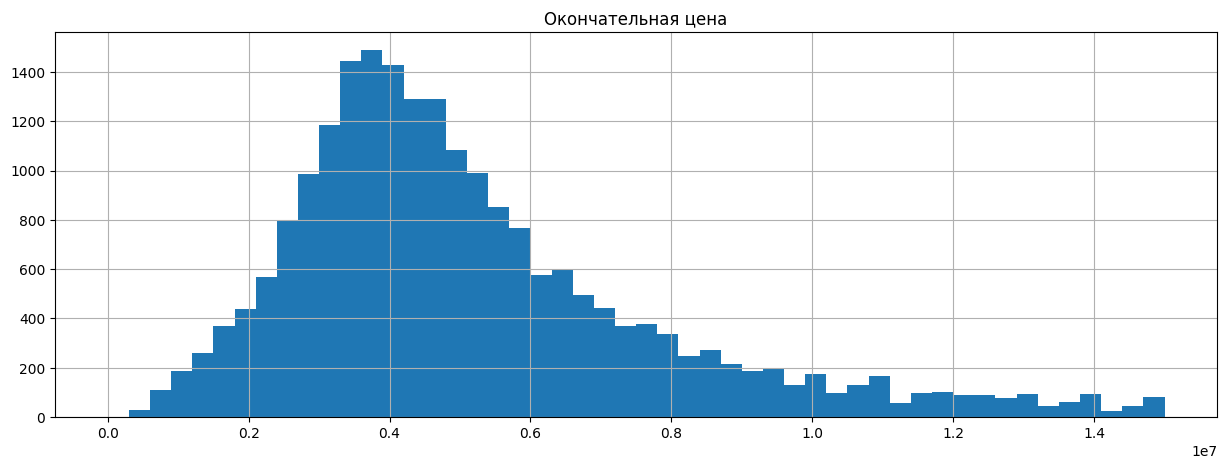

count    2.153100e+04
mean     5.143169e+06
std      2.665095e+06
min      1.219000e+04
25%      3.399000e+06
50%      4.500000e+06
75%      6.300000e+06
max      1.500000e+07
Name: last_price, dtype: float64

In [378]:
df.last_price.hist(bins=50, range=(0, 1.5e+7), figsize=(15,5))
plt.title('Окончательная цена')
plt.show()
df.last_price.describe()

Большая часть данных представлена квартирами от 3.4 млн и до 6.5 млн. Наиболее редкими квартирами считаются квартиры больше 10 млн рублей

##### Анализ days_exposition

In [379]:
df.days_exposition.describe()

count    18852.000000
mean       175.893698
std        215.169280
min          1.000000
25%         44.000000
50%         92.000000
75%        223.000000
max       1580.000000
Name: days_exposition, dtype: float64

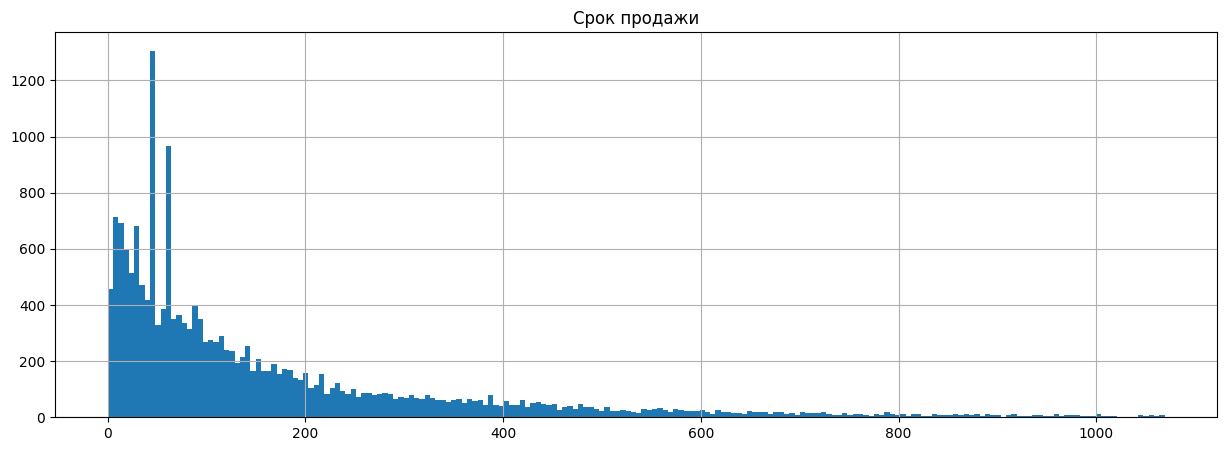

In [380]:
df.days_exposition.hist(bins=200, figsize=(15,5), range=(0, 1069))
plt.title("Срок продажи")
plt.show()

In [381]:
df = df.drop(df.loc[df['days_exposition'] > 1200].index).reset_index(drop=True)
df.shape

(21457, 23)

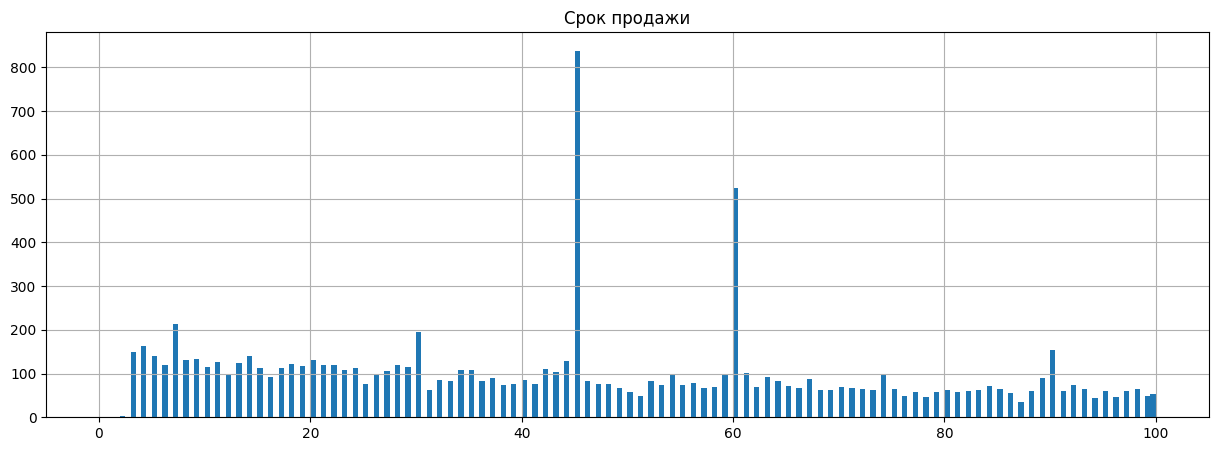

In [382]:
df.days_exposition.hist(bins=200, figsize=(15,5), range=(0, 100))
plt.title("Срок продажи")
plt.show()

Уберем аномально быстрые продажи

In [383]:
df = df.drop(df.loc[df['days_exposition'] < 3].index).reset_index(drop=True)
df.shape

(21453, 23)

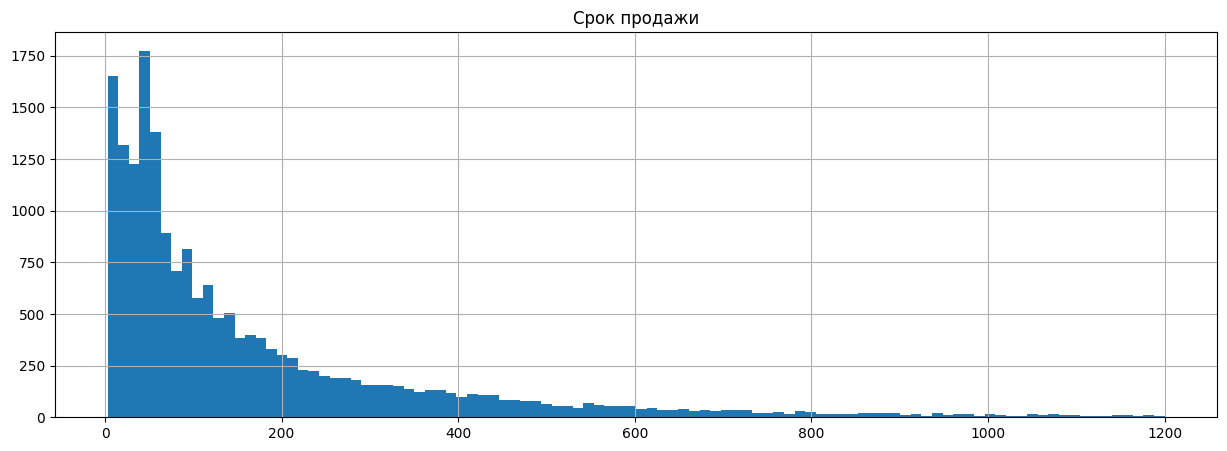

count    18774.000000
mean       171.378555
std        202.904613
min          3.000000
25%         44.000000
50%         92.000000
75%        219.000000
max       1200.000000
Name: days_exposition, dtype: float64

In [384]:
df.days_exposition.hist(bins=100, figsize=(15,5))
plt.title("Срок продажи")
plt.show()
df.days_exposition.describe()

Большенство данных расположено в районе 42-191 дня. Распределение имеет длинный "хвост" на протяжении всего количества дней. Также имеются пиковые значения, которые будут проанализированы позже.

##### Анализ living_area

In [385]:
df.living_area.describe()

count    19753.000000
mean        31.265755
std         14.224303
min          2.000000
25%         18.200000
50%         29.700000
75%         40.000000
max        117.100000
Name: living_area, dtype: float64

In [386]:
df.living_area.describe()

count    19753.000000
mean        31.265755
std         14.224303
min          2.000000
25%         18.200000
50%         29.700000
75%         40.000000
max        117.100000
Name: living_area, dtype: float64

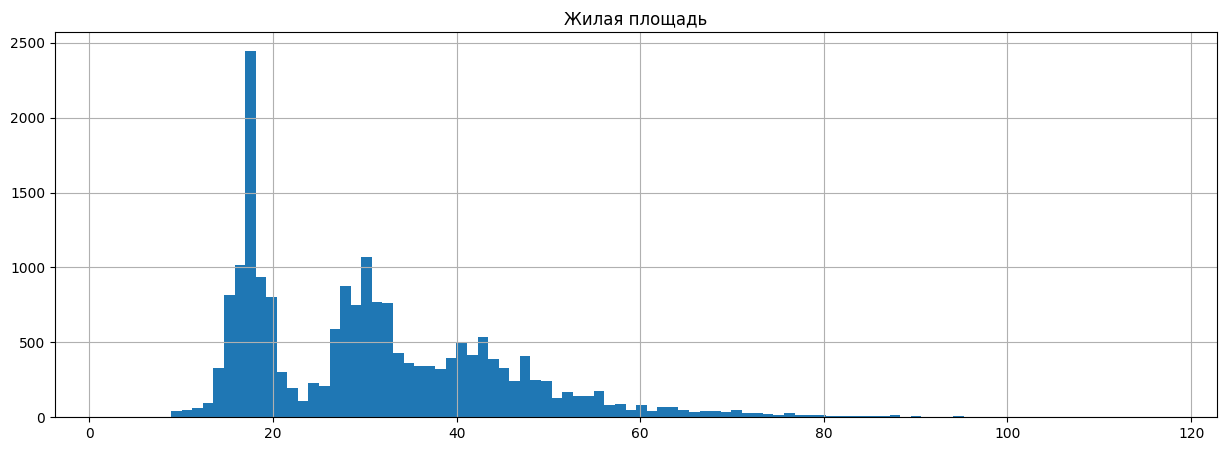

In [387]:
df.living_area.hist(bins=100, figsize=(15,5))
plt.title('Жилая площадь')
plt.show()

In [388]:
df.living_area = df.query('(living_area >= 10) & (living_area <= 80)').living_area
df.living_area = df.living_area.astype('float')
df.shape

(21453, 23)

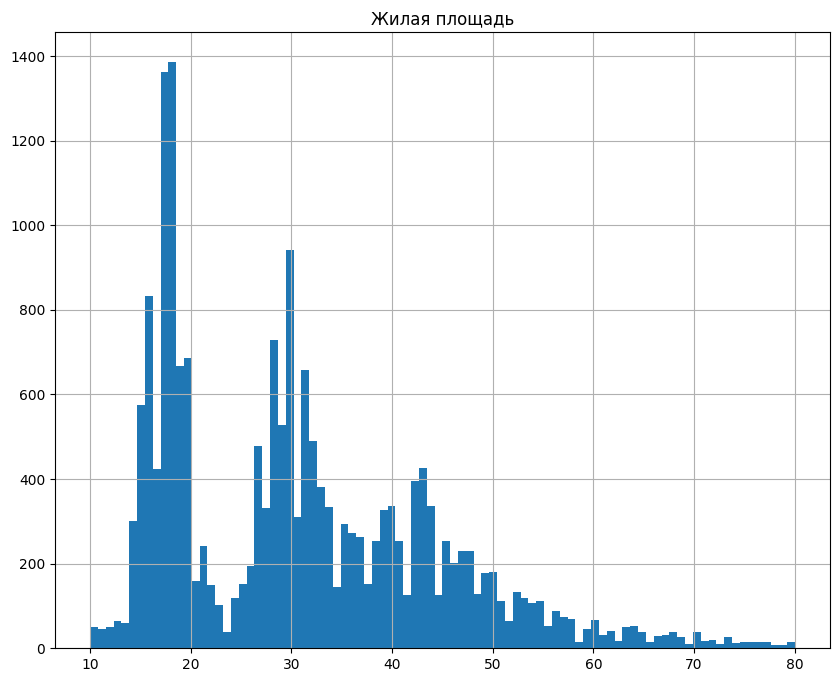

count    19600.000000
mean        30.899136
std         13.399702
min         10.000000
25%         18.200000
50%         29.500000
75%         40.000000
max         80.000000
Name: living_area, dtype: float64

In [389]:
df['living_area'].hist(bins=90, figsize=(10, 8))
plt.title('Жилая площадь')
plt.show()
df.living_area.describe()

Имеются пиковые значения примерно возле 17 и 30 кв метров. После 50 кв метров, идет уменьшение количества квартир по этому параметру

##### Анализ kitchen_area

In [390]:
df.kitchen_area.describe()

count    19365.000000
mean         9.777733
std          4.049323
min          1.300000
25%          7.000000
50%          9.000000
75%         11.100000
max         64.000000
Name: kitchen_area, dtype: float64

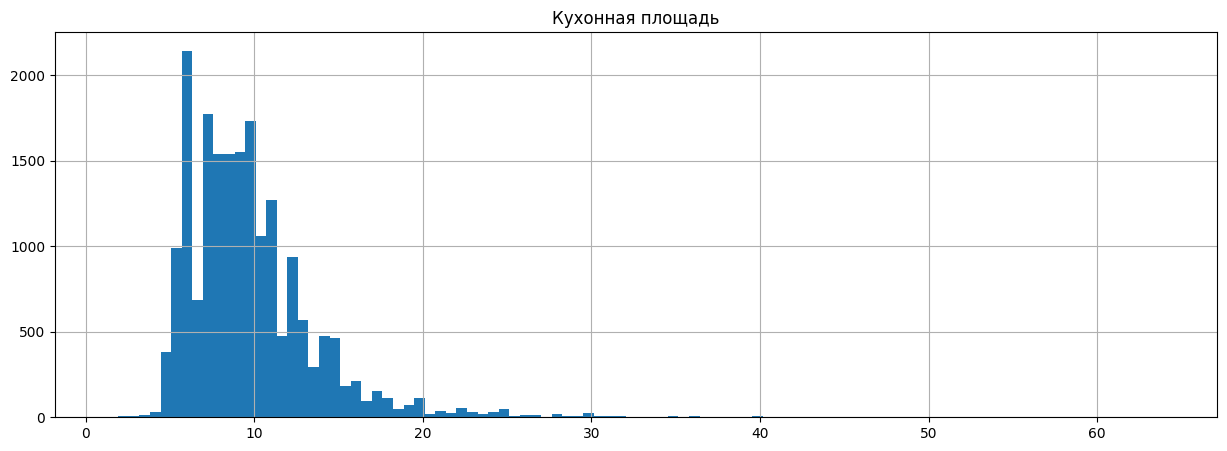

In [391]:
df.kitchen_area.hist(bins=100, figsize=(15,5))
plt.title('Кухонная площадь')
plt.show()

In [392]:
df.kitchen_area = df.query('(kitchen_area >= 5) & (kitchen_area <= 30)').kitchen_area
df.kitchen_area = df.kitchen_area.astype('float')
df.shape

(21453, 23)

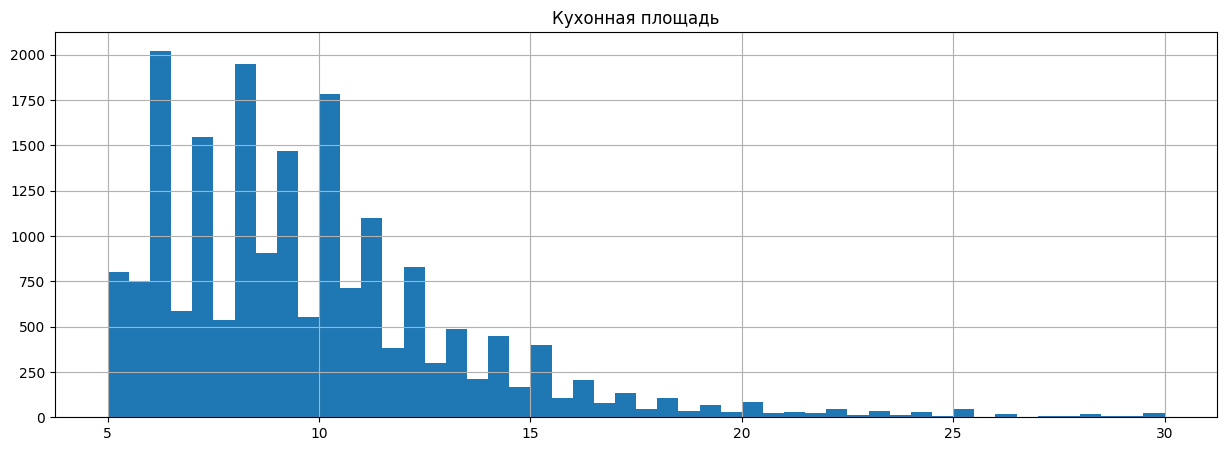

In [393]:
df.kitchen_area.hist(bins=50, figsize=(15,5))
plt.title('Кухонная площадь');

Большая часть объектов недвижимости имеют площадь кухни от 5.5 до 12 кв м. Самый распространенный вариант - около 5.5 кв м. 

#### Проверка синтетических данных kitchen_area и living_area

In [394]:
total_area_filter = df.total_area*0.9 <= (df.living_area + df.kitchen_area)
total_area_filter.value_counts() 

False    21453
Name: count, dtype: int64

In [395]:
df[total_area_filter]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_Centers_nearest_km


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:896: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


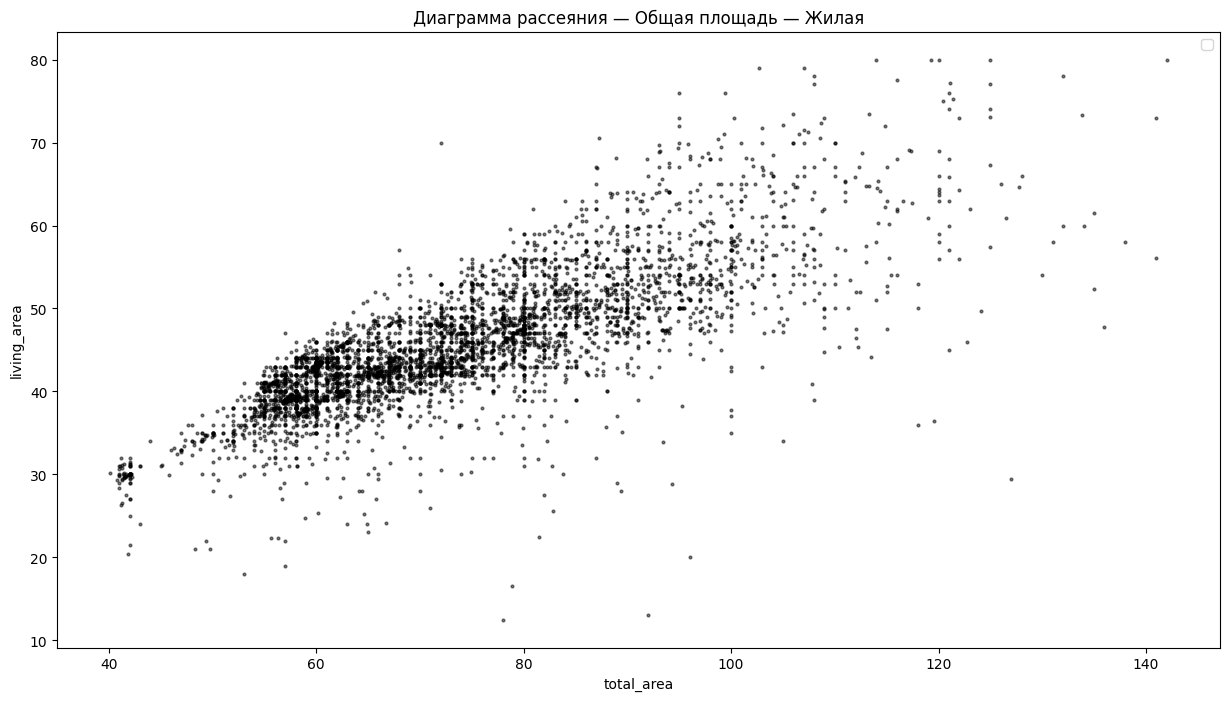

In [396]:
# check
df[df['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

#### Проверка на экстримальные значения

In [397]:
(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min','median', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,453.00","21,453.00","21,453.00","18,774.00","21,453.00","19,600.00","19,202.00","21,453.00","21,375.00"
min,0.00,12.00,2.00,3.00,"12,190.00",10.00,5.00,1.00,1.00
median,2.00,50.10,2.65,92.00,"4,500,000.00",29.50,9.00,4.00,9.00
max,7.00,150.00,3.49,"1,200.00","15,000,000.00",80.00,30.00,25.00,26.00


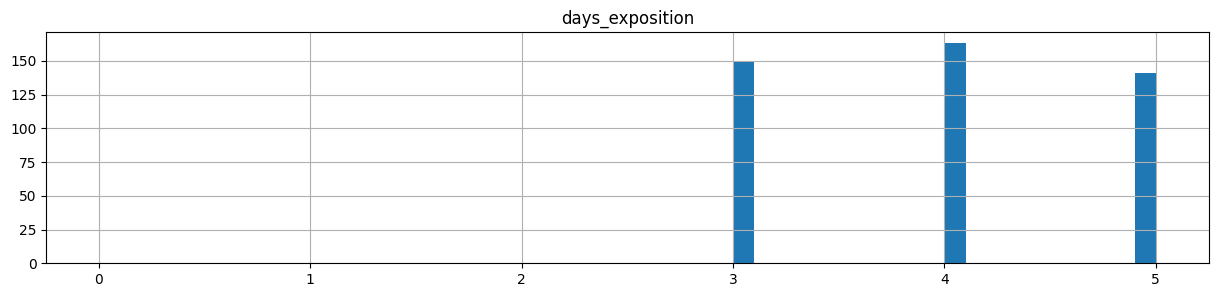

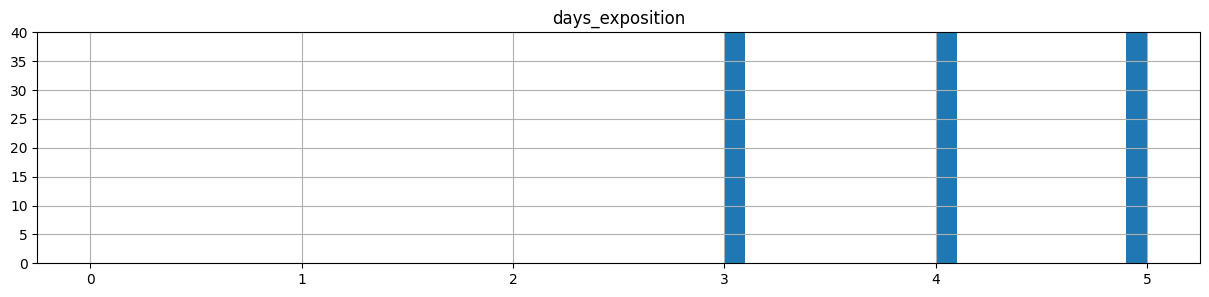

In [398]:
# check
df.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

df.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [399]:
# мы заполнили пропуски в первых 15 столбиках
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21453 entries, 0 to 21452
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             21453 non-null  int64         
 1   last_price               21453 non-null  int64         
 2   total_area               21453 non-null  float64       
 3   first_day_exposition     21453 non-null  datetime64[ns]
 4   rooms                    21453 non-null  int64         
 5   ceiling_height           21453 non-null  float64       
 6   floors_total             21375 non-null  float64       
 7   living_area              19600 non-null  float64       
 8   floor                    21453 non-null  int64         
 9   is_apartment             21453 non-null  bool          
 10  studio                   21453 non-null  bool          
 11  open_plan                21453 non-null  bool          
 12  kitchen_area             19202 n

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_Centers_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,2,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,14.0
3,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,8.0
4,10,2890000,30.4,2018-09-10,1,2.65,12.0,14.4,5,False,...,0,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN


### Добавьте в таблицу новые столбцы

In [400]:
# Обозначим новую функцию для присвоения категорий к этажа
def floor_name(floor, floors_total):
        floor = abs(floor)
        floors_total = abs(floors_total)
        if (floor == 1) or (floor == 0):
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        else:
            return 'другой'

In [401]:
df['meter_price'] = round(df.last_price / df.total_area, 2)

df['weekday_exposition'] = df['first_day_exposition'].dt.weekday

df['month_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).month

df['year_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).year

df['floor_name'] = df.apply(lambda x: floor_name(x['floor'], x['floors_total']), axis=1)

df['floor_name'].value_counts()

floor_name
другой       15790
последний     2947
первый        2716
Name: count, dtype: int64

### Проведите исследовательский анализ данных

Список параметров:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего парка

#### Анализ cityCenters_nearest

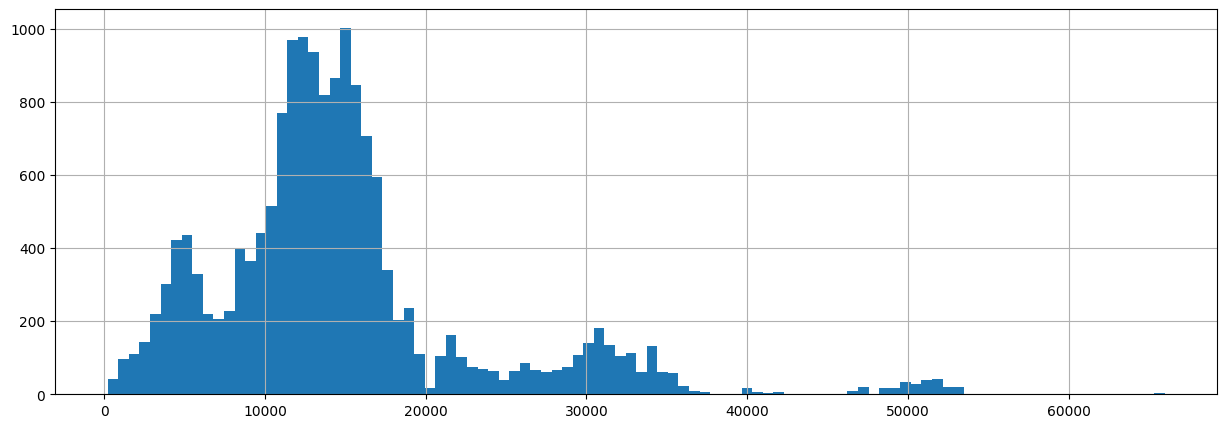

count    16330.000000
mean     14716.996571
std       8565.514698
min        208.000000
25%      10294.750000
50%      13378.000000
75%      16505.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [402]:
df.cityCenters_nearest.hist(bins=100, figsize=(15,5))
plt.show()
df.cityCenters_nearest.describe()

Видно что данные в основном лежат в районе 10-16 км от центра. Рассмотрим значения которые оказались сильнее дальше

In [403]:
df.loc[df['cityCenters_nearest'] > 30000].locality_name.value_counts()

locality_name
Колпино         311
Петергоф        188
Сестрорецк      172
Пушкин          137
Ломоносов       131
Шушары          100
Кронштадт        91
Красное Село     65
Павловск         35
Зеленогорск      21
Понтонный        20
Саперный          6
Молодежное        5
Репино            2
Щеглово           1
Белоостров        1
Name: count, dtype: int64

Видно что некоторые квартиры находятся слишком далеко от центра места где они расположены. Возможно автоматически вышла ошибка, которая определила центры данных квартир к другому месту (Санкт-Петербургу), а не своему месту и назначила большее расстояние для них.

#### Анализ parks_nearest

count    6987.000000
mean      491.167597
std       333.717831
min         1.000000
25%       292.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64

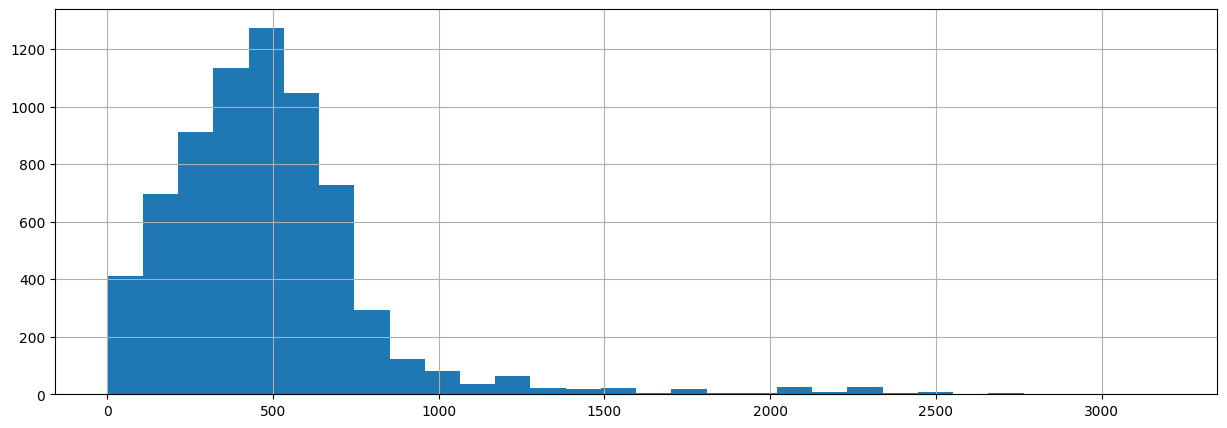

In [404]:
df.parks_nearest.hist(bins=30, figsize=(15,5))
plt.show
df.parks_nearest.describe()

In [405]:
df.loc[df['parks_nearest'] > 1500].locality_name.value_counts()

locality_name
Санкт-Петербург    123
Петергоф             8
Колпино              5
Name: count, dtype: int64

Данные распределены что примерно находятся в районе 288-612 метров от парков. Так как много данных пропущено сделаем вывод, что здесь имеется выборка наиболее крупных населенных пунктов, что можем видеть на столбике ниже

In [406]:
df.loc[~(df.parks_nearest.isna())].locality_name.value_counts()

locality_name
Санкт-Петербург    6246
Пушкин              196
Петергоф            135
Колпино             131
Кронштадт            83
Сестрорецк           68
Красное Село         43
Павловск             24
Стрельна             19
Зеленогорск          16
Ломоносов            16
Парголово            10
Name: count, dtype: int64

#### Анализ airports_nearest

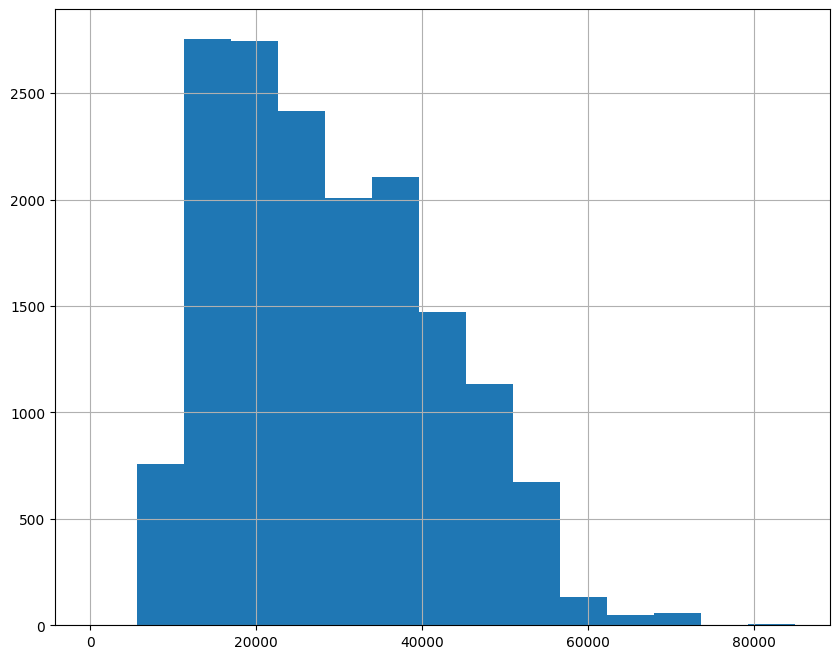

count    16315.000000
mean     28837.023291
std      12850.570904
min          0.000000
25%      18141.500000
50%      26956.000000
75%      37473.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [407]:
df['airports_nearest'].hist(bins=15, figsize=(10, 8))
plt.show()
df['airports_nearest'].describe()

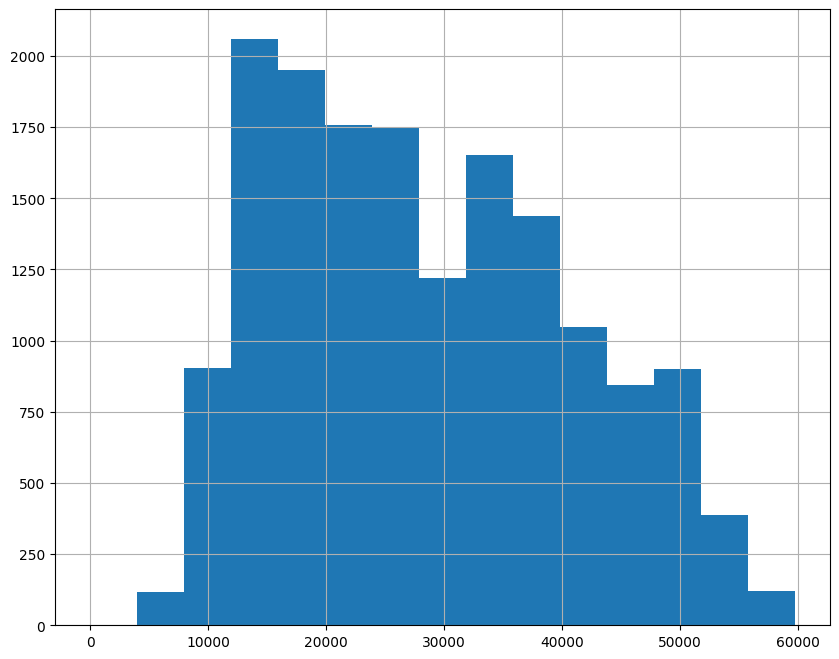

count    16315.000000
mean     28837.023291
std      12850.570904
min          0.000000
25%      18141.500000
50%      26956.000000
75%      37473.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [408]:
df.loc[df['airports_nearest']<60000, 'airports_nearest'].hist(bins=15, figsize=(10, 8))
plt.show()
df['airports_nearest'].describe()

Большинство квартир находятся от 18 до 37 км от аэропорта. Медиана равна 27 км

#### check gap

In [409]:
# check
data = df.copy()

In [410]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21453 entries, 0 to 21452
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             21453 non-null  int64         
 1   last_price               21453 non-null  int64         
 2   total_area               21453 non-null  float64       
 3   first_day_exposition     21453 non-null  datetime64[ns]
 4   rooms                    21453 non-null  int64         
 5   ceiling_height           21453 non-null  float64       
 6   floors_total             21375 non-null  float64       
 7   living_area              19600 non-null  float64       
 8   floor                    21453 non-null  int64         
 9   is_apartment             21453 non-null  bool          
 10  studio                   21453 non-null  bool          
 11  open_plan                21453 non-null  bool          
 12  kitchen_area             19202 n

In [411]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,453.00","21,453.00","21,453.00","18,774.00","21,453.00","19,600.00","19,202.00","21,453.00","21,375.00"
min,0.00,12.00,2.00,3.00,"12,190.00",10.00,5.00,1.00,1.00
max,7.00,150.00,3.49,"1,200.00","15,000,000.00",80.00,30.00,25.00,26.00


In [412]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [413]:
# check
df_check.rooms.value_counts().to_frame()

,count
rooms,
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12


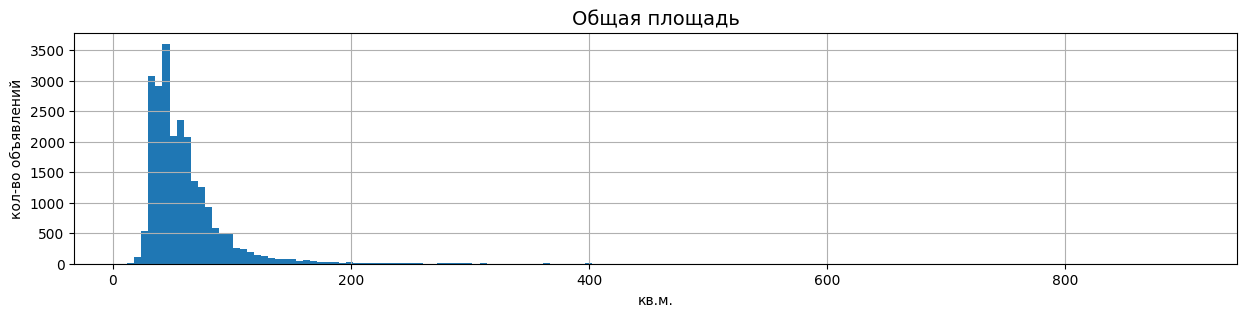

In [414]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />т.е. все квартиры менее 20-ти и более 250-ти квадратных метров можно считать редкостями
       

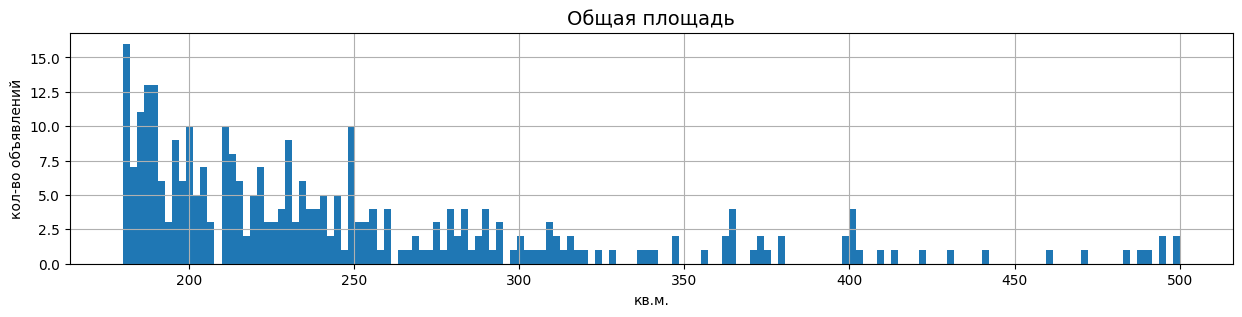

In [415]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

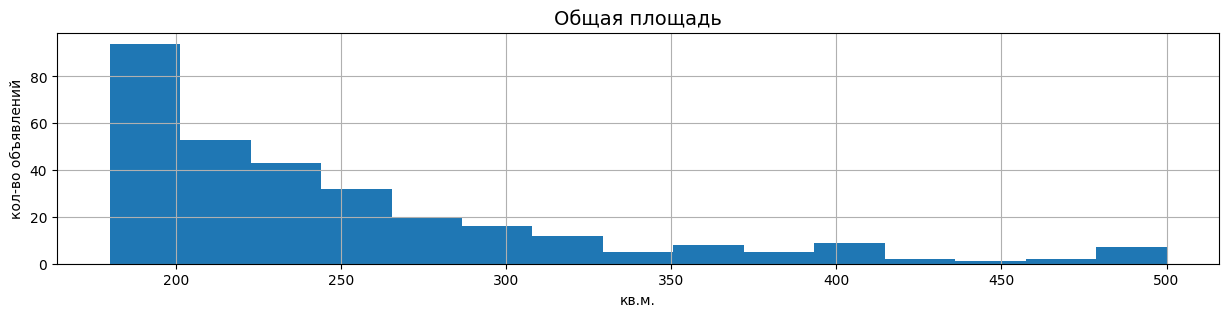

In [416]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

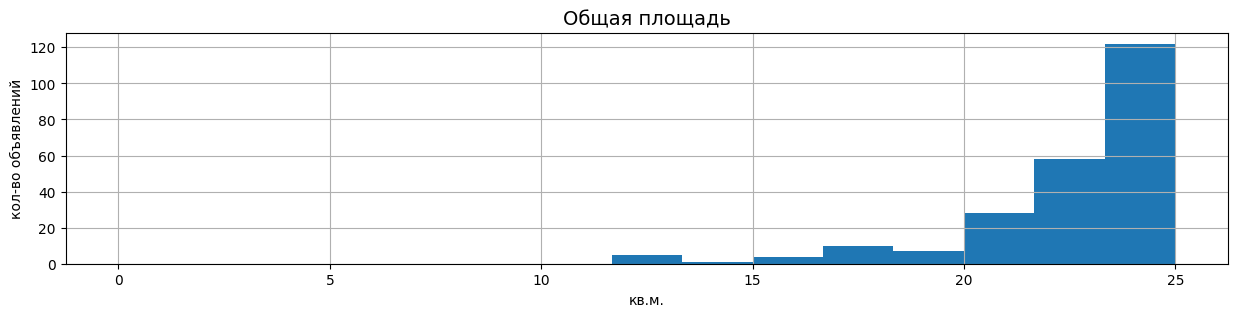

In [417]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25))
plt.title('Общая площадь', fontsize=14)
plt.xlabel('кв.м.')
plt.ylabel('кол-во объявлений');

<div class="alert alert-d anger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Осталось завершить выполнение пункта 4.1 из брифа проекта (в старой версии п.2.4)

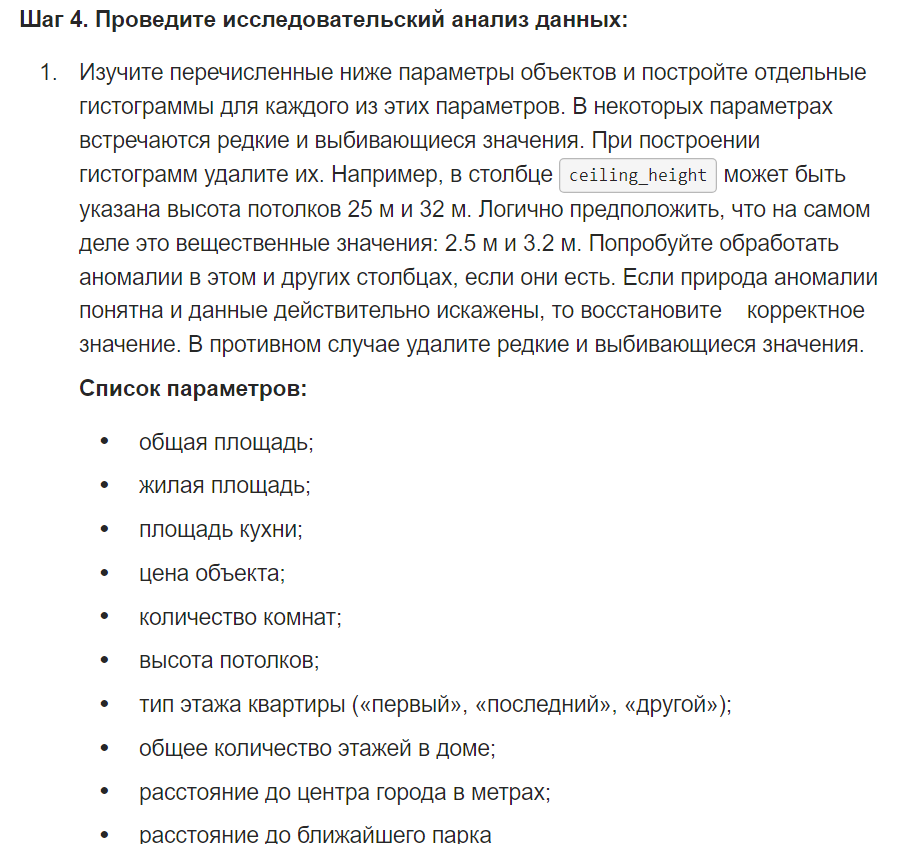
        
__Критичный уровень потерь записей на этапе предобработки составляет 10%, оптимальный 5%__
        
Если при фильтрации одной колонки, на этом проекте, теряем больше одного процента данных от изначального объема, стоит еще раз пересмотреть условия фильтрации        

In [418]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,0.00,20.00,2.40,3.00,"560,000.00",10.00,5.00,1.00,2.00
0.010000,1.00,25.18,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.500000,2.00,50.10,2.65,92.00,"4,500,000.00",29.50,9.00,4.00,9.00
0.990000,4.00,120.00,3.30,974.00,"13,900,000.00",70.00,23.40,22.00,25.00
0.998800,5.00,145.00,3.40,"1,161.94","15,000,000.00",78.00,29.78,25.00,26.00


<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера </b></font>
    <br /> 
    <font size="3", color = "black">
<br />Квантили что это такое (первая ссылка иногда не открывается)
        
https://fin-accounting.ru/cfa/l1/quantitative/cfa-quartiles-quintiles-deciles-percentiles?ysclid=l7gy2kky4i156375632
        
https://www.codecamp.ru/blog/percentile-vs-quartile-vs-quantile/?ysclid=lg89wjm4zz267333250        
        
они помогают увидеть редкости и аномалии в данных

# example 1

#### example 3

##### example 4

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />
Стоит выделять разделы проекта заголовками разного уровня, за уровень отвечает количество знаков #
    
        # example 1

        #### example 3

        ##### example 4
    
Пожалуйста, воспользуйся методичкой по оформлению проектов. Ее можно найти в блоке курса: Полезные инструкции для учёбы - Оформление проекта - Рекомендации по выполнению проектов    

#### Анализ weekday_exposition

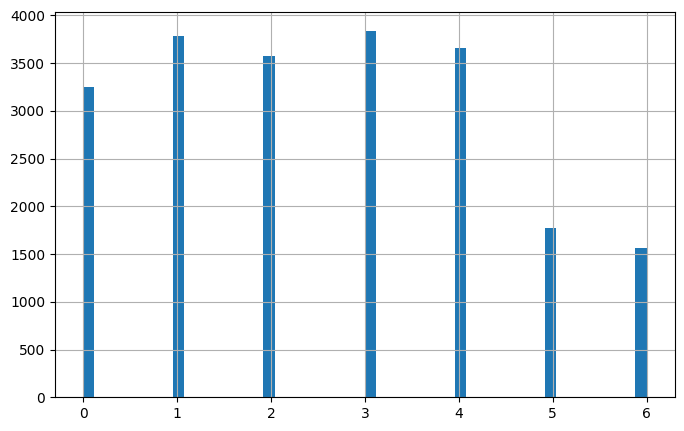

count    21453.000000
mean         2.580199
std          1.793940
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64

In [419]:
df.weekday_exposition.hist(bins=50, figsize=(8,5))
plt.show()

df.weekday_exposition.describe()

Из данных видно, что квартиры хуже продавались в выходные дни, на динамике будних дней провалов не обнаружено.

#### Анализ month_exposition

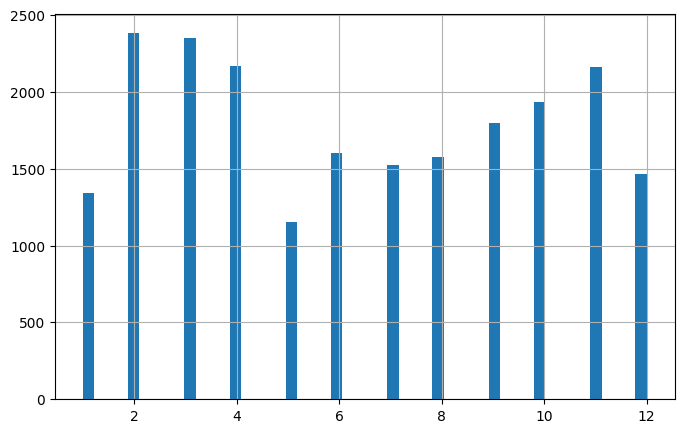

month_exposition
2     2385
3     2353
4     2165
11    2163
10    1934
9     1795
6     1599
8     1576
7     1522
12    1464
1     1344
5     1153
Name: count, dtype: int64

In [420]:
df.month_exposition.hist(bins=50, figsize=(8,5))
plt.show()

df.month_exposition.value_counts()

На графике видно что чаще всего квартиры выставляли либо в начале года, 2,3,4 месяца, либо ближе к концу 9,10,11 месяцы. Меньше всего выставляли на продажу в начале года 1272 объявления и в конце 1361 объявление. В мае после спада до 1073 объявлений начанался восходящий тренд до декабря

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Скорее всего потому что зимой декабрь-январь люди на зимних праздниках, в феврале обычно сезон каникул заканчивается, лето тоже связан с отдыхом, поэтому активность не такая большая. Так что наибольшие продажи приходятся на осень и весну-конец зимы
        

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️  Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
        
__Интересно, почему февраль (самый короткий месяц) опережает все месяцы — ?__

#### Анализ year_exposition

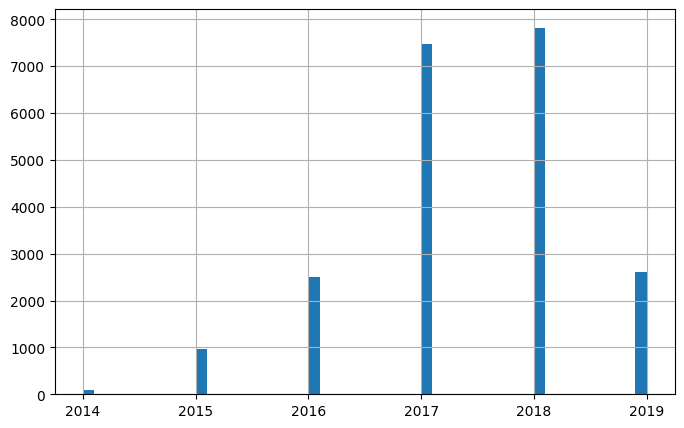

year_exposition
2018    7823
2017    7472
2019    2612
2016    2495
2015     967
2014      84
Name: count, dtype: int64

In [421]:
df.year_exposition.hist(bins=50,figsize=(8,5))
plt.show()

df.year_exposition.value_counts()

2017-2018 года стали самыми популярными по количеству объявлений 7292 и 7755 соответсвенно. Наименее популярный год был 2014 всего 30 объявлений. Можно сделать 2 предположения из данных по годам. 1) в 2014 сервис был не настолько популярным и в течение последующих лет стремительно набрал популярность. 2) данные по предыдущим годам плохо сохранились.

#### Анализ floor_name

floor_name
другой       15790
последний     2947
первый        2716
Name: count, dtype: int64

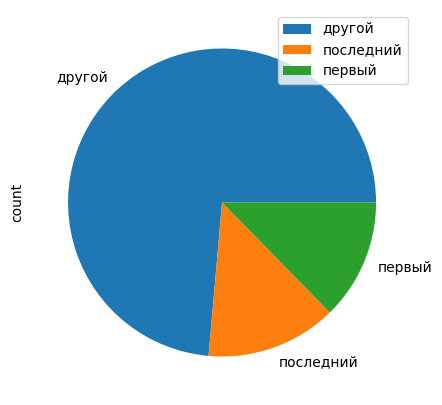

In [422]:
df.floor_name.value_counts().plot(kind='pie', figsize=(8,5), legend=True)
df.floor_name.value_counts()

Из диаграммы видно, что наиболее популярные - это квартиры с каким либо средним этажем, меньше всего квартир на первом этаже

### Задание как быстро продавались квартиры

In [423]:
df.days_exposition.describe()

count    18774.000000
mean       171.378555
std        202.904613
min          3.000000
25%         44.000000
50%         92.000000
75%        219.000000
max       1200.000000
Name: days_exposition, dtype: float64

Примем за "необычно быстрые продажи", продажи ниже 42 дней (25% данных), а за "необычно долгие" больше 190 дней (75% данных) 

In [424]:
display("необычно быстрые продажи", df.loc[df['days_exposition'] < 42].days_exposition.count())
display("необычно долгие продажи", df.loc[df['days_exposition'] > 190].days_exposition.count())

'необычно быстрые продажи'

4434

'необычно долгие продажи'

5440

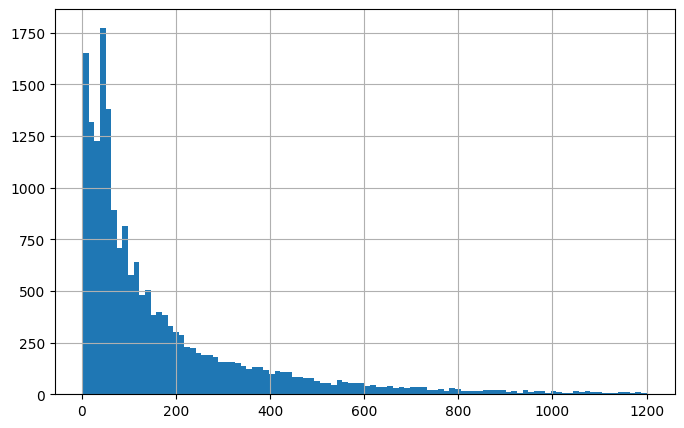

In [425]:
df.days_exposition.hist(bins=100,figsize=(8,5))
plt.show()

Обычно квартиры продают за год-полтора. Видно медиана равна 86 дней, а среднее 136 дней. Величины отличаются почти в 2 раза, скорее всего из-за того, что на среднее сильно влияют необычно долгие продажи.
Также внимательно рассмотрим пиковые значения до 100 дней


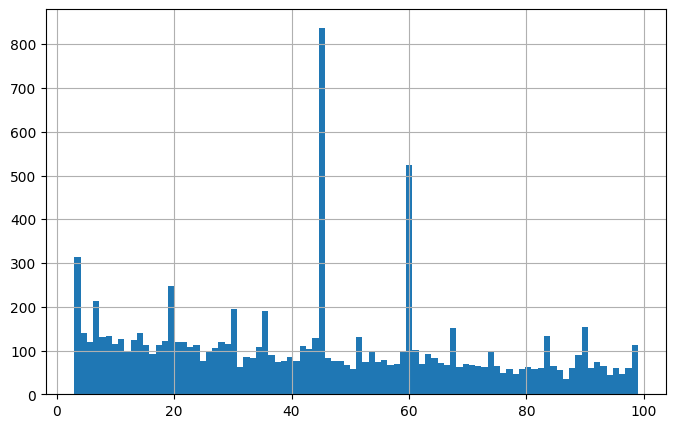

In [426]:
df.loc[df['days_exposition'] < 100].days_exposition.hist(bins=90,figsize=(8,5))
plt.show()

На графике пиковые значения в районе 45 и 60 дней. Можно утверждать, что чаще всего квартиры продаются за такой срок, однако важно учесть неполное заполнение столбца days_exposition, которое может привести к искажению данных

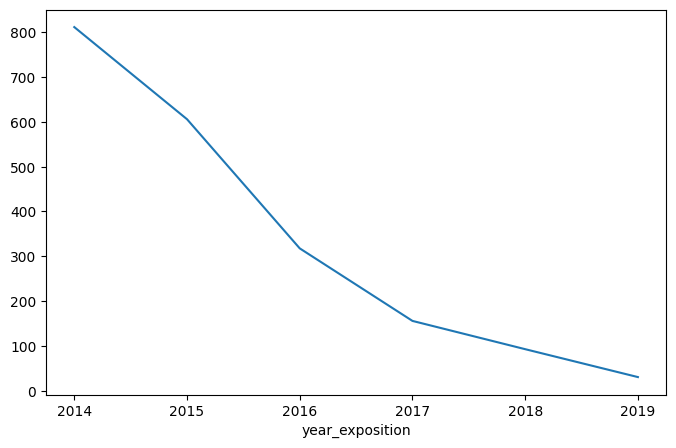

In [427]:
(
    df.loc[~(df['days_exposition'] == 45) | ~(df['days_exposition'] == 60)]
    .groupby('year_exposition').days_exposition.mean().plot(figsize=(8,5))
)
plt.show()

C 2014 года идет тренд на уменьшение среднего времении на продажу квартиры

### Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта

In [428]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
df[numeric_cols].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_Centers_nearest_km,meter_price,weekday_exposition,month_exposition,year_exposition
total_images,1.000000,0.160049,0.107760,0.085476,0.001863,0.017866,0.099202,0.036109,0.059006,0.046389,...,0.000450,-0.007663,-0.028554,0.005384,-0.028788,-0.032600,0.125363,-0.009099,0.007993,0.147105
last_price,0.160049,1.000000,0.742515,0.477624,-0.000829,0.162063,0.607303,0.117177,0.534333,0.062159,...,0.137880,0.049477,0.158127,-0.065790,0.093753,-0.358987,0.634385,-0.013454,0.004817,-0.005770
total_area,0.107760,0.742515,1.000000,0.804328,-0.004053,-0.031092,0.913681,-0.029246,0.476752,0.053902,...,0.085787,0.001931,0.110569,-0.041485,0.129622,-0.173705,0.001724,-0.008451,0.008449,-0.066927
rooms,0.085476,0.477624,0.804328,1.000000,-0.004651,-0.225722,0.894039,-0.167638,0.083845,0.002845,...,0.070908,-0.045621,0.039790,-0.015937,0.095802,-0.110655,-0.174062,0.000360,-0.001309,-0.038098
ceiling_height,0.001863,-0.000829,-0.004053,-0.004651,1.000000,0.000327,-0.009739,-0.009414,0.000213,-0.001331,...,-0.006316,-0.003641,-0.007374,0.002666,-0.009310,0.008831,0.003335,-0.003083,-0.002840,0.006523
floors_total,0.017866,0.162063,-0.031092,-0.225722,0.000327,1.000000,-0.164162,0.665524,0.336186,0.174071,...,-0.236776,0.106767,-0.126763,0.052046,-0.046318,-0.024828,0.319101,0.009960,0.012873,0.002752
living_area,0.099202,0.607303,0.913681,0.894039,-0.009739,-0.164162,1.000000,-0.124391,0.189502,0.020598,...,0.096973,-0.035471,0.079698,-0.026902,0.107533,-0.144311,-0.094526,-0.003137,-0.002976,-0.048434
floor,0.036109,0.117177,-0.029246,-0.167638,-0.009414,0.665524,-0.124391,1.000000,0.226004,0.166673,...,-0.151387,0.080418,-0.078708,0.040536,-0.037679,-0.012574,0.235446,0.009651,0.013917,0.006294
kitchen_area,0.059006,0.534333,0.476752,0.083845,0.000213,0.336186,0.189502,0.226004,1.000000,0.082126,...,-0.004166,0.071658,0.115162,-0.066566,0.067084,-0.150165,0.274349,-0.007875,0.016289,-0.042633
balcony,0.046389,0.062159,0.053902,0.002845,-0.001331,0.174071,0.020598,0.166673,0.082126,1.000000,...,-0.077057,0.030797,-0.043431,0.023186,-0.025836,0.059659,0.038509,-0.001147,0.004538,0.005348


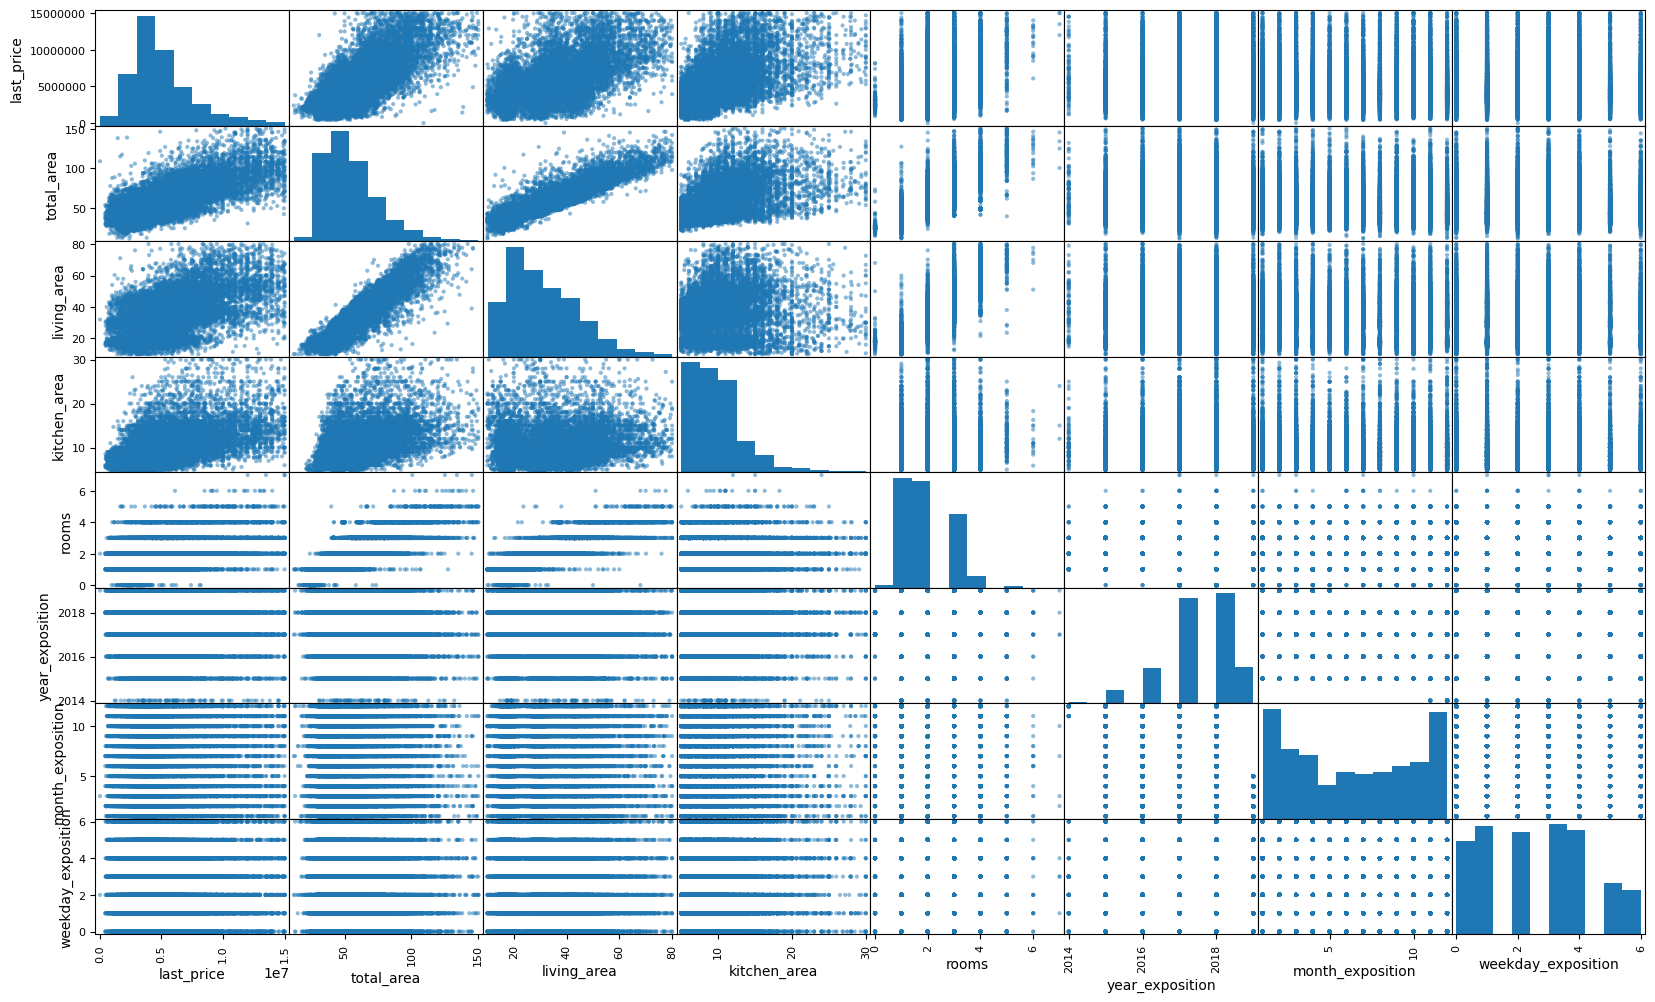

In [429]:
pd.plotting.scatter_matrix(df[['last_price', 'total_area', 'living_area', 'kitchen_area',
                               'rooms', 'floor_name', 'year_exposition', 'month_exposition',
                               'weekday_exposition']], figsize=(20,12))
plt.show()

Как видно из построенных выше графиков и подсчитанной корреляции между ценой объекта и другими параметрами, наибольшее влияние на цену объекта оказывает общая площадь, имея положительную корреляцию 0.74.Далее идут такие параметры как жилая площадь с корреляцией 0.59 и площадь кухни с корреляцией 0.40. Меньшее значение положительной связи у параметра количества комнат 0.36

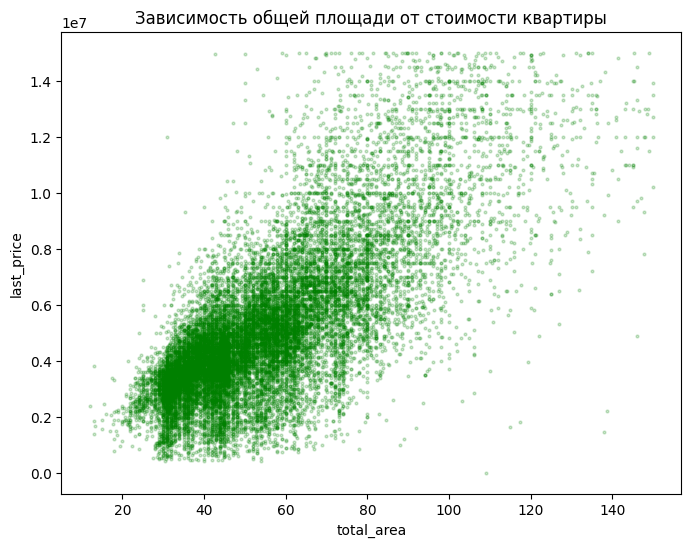

In [430]:
df.plot(x='total_area', y ='last_price', kind ='scatter', figsize=(8, 6), alpha = 0.2, c = 'g', s = 4)

plt.title('Зависимость общей площади от стоимости квартиры')
plt.show()

Существует положительная зависимость между общей площадью и ценой

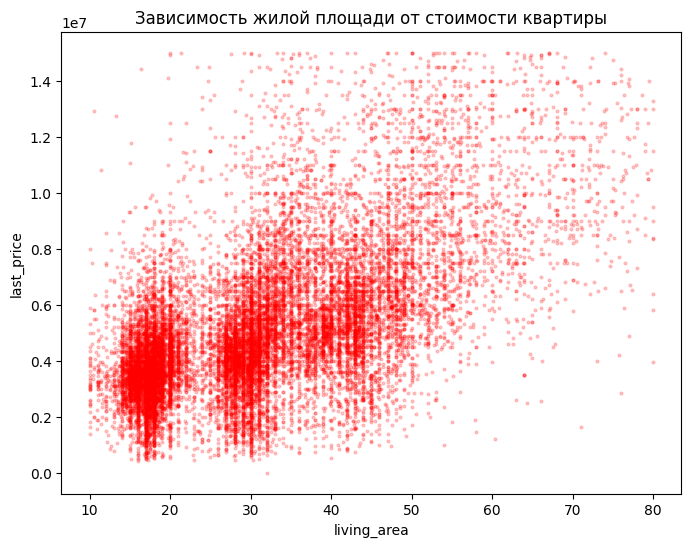

In [431]:
df.plot(x='living_area', y ='last_price', kind ='scatter', figsize=(8, 6), alpha = 0.2, c = 'r', s = 4)

plt.title('Зависимость жилой площади от стоимости квартиры')
plt.show()

Существует положительная зависимость между жилой площадью и ценой, видно также "широкие" значения между 15-20 метров и 25-30 метров, которые незначительно влияют на цену квартиры, однако при увеличении площади зависимость прослеживается более явно. 

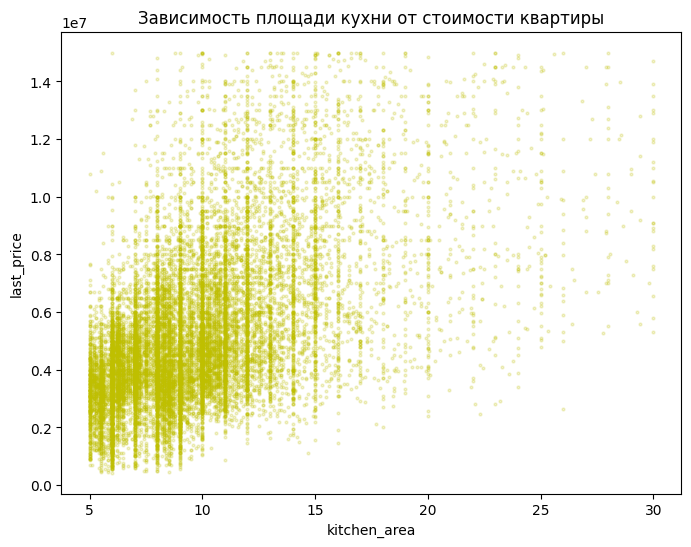

In [432]:
df.plot(x='kitchen_area', y ='last_price', kind ='scatter', figsize=(8, 6), alpha = 0.2, c = 'y', s = 4)

plt.title('Зависимость площади кухни от стоимости квартиры')
plt.show()

есть зависимость увеличения цены от увеличения площади кухни

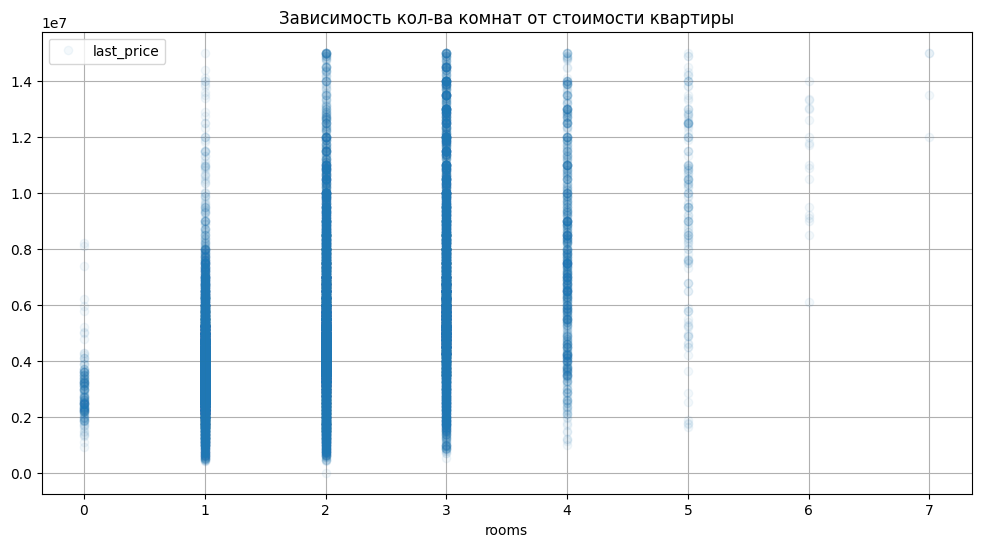

In [433]:
df.plot(x = 'rooms', y = 'last_price', style='o', grid=True, figsize=(12, 6), alpha=0.05)
plt.title('Зависимость кол-ва комнат от стоимости квартиры')
plt.show()

До 3-ех комнат, квартиры положительно растут в цене однако после 3ей комнаты цена выше не идет

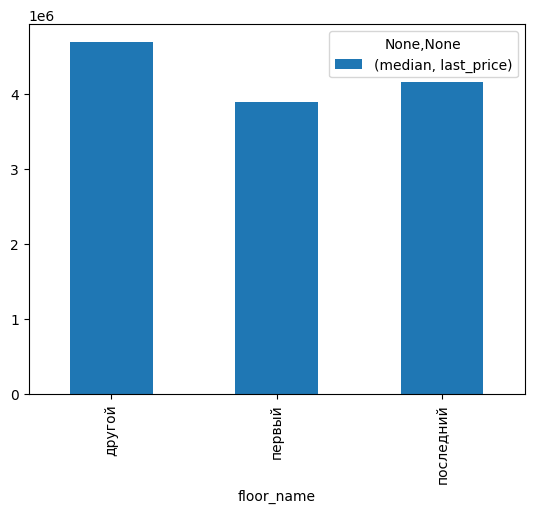

In [434]:
floor_name = df.pivot_table(index = 'floor_name',
                                values = 'last_price',
                                aggfunc = ['count', 'median'])
floor_name.plot(y = [('median','last_price')],kind='bar', legend=True)
plt.show()

Медианное значение для квартир на первом этаже самое минимальное, скорее всего из-за непривлекательности такого рода квартир. Различия для других или последних этажей минимальны

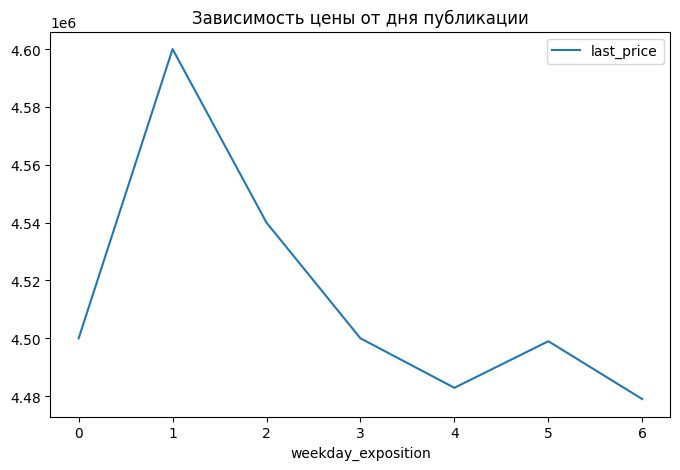

In [435]:
(
    df.pivot_table(index='weekday_exposition', values='last_price', aggfunc='median')
    .plot(figsize=(8, 5))
)
plt.title('Зависимость цены от дня публикации')
plt.show()

Самая высокая цена во вторник, затем начинает снижаться до конца недели

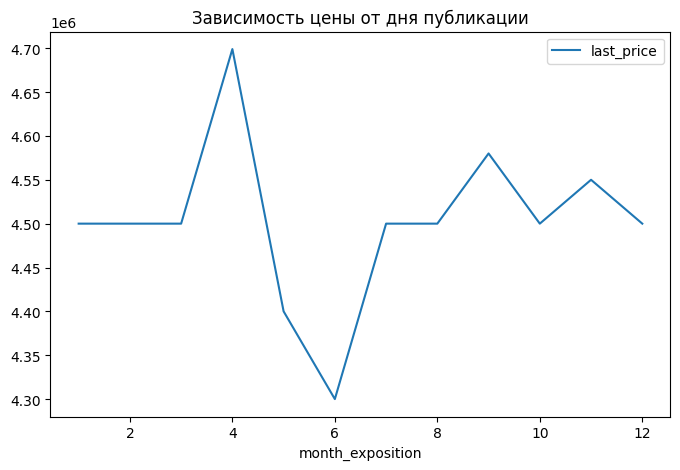

In [436]:
(
    df.pivot_table(index='month_exposition', values='last_price', aggfunc='median')
    .plot(figsize=(8, 5))
)
plt.title('Зависимость цены от дня публикации')
plt.show()

Самая высокая цена наблюдается в апреле, достигает своего дна в июне и начинает рост до сентября, и потом начинает плавно снижаться

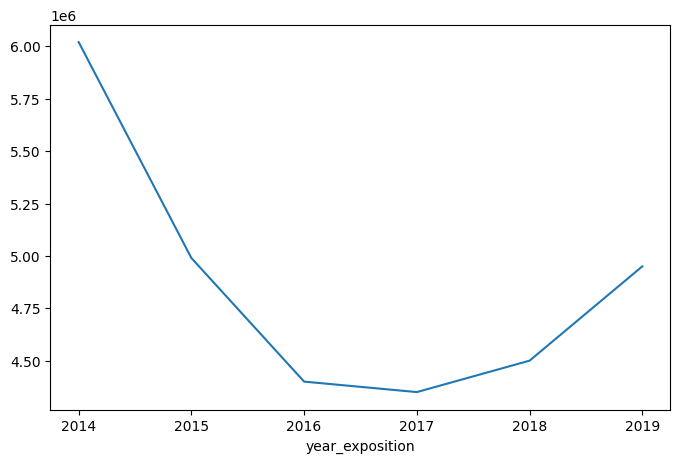

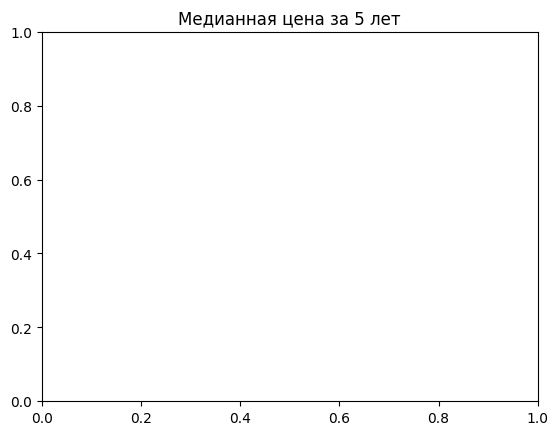

In [437]:
df.groupby('year_exposition').last_price.median().plot(figsize=(8,5))
plt.show()
df.groupby('year_exposition').last_price.median()
plt.title('Медианная цена за 5 лет');

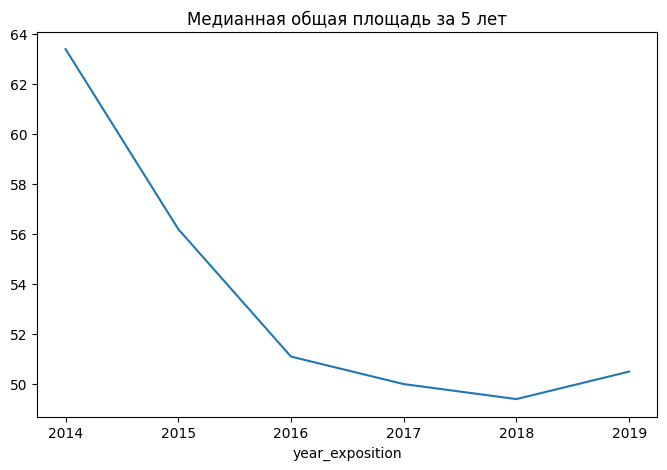

In [438]:
df.groupby('year_exposition').total_area.median().plot(figsize=(8,5))
plt.title('Медианная общая площадь за 5 лет')
plt.show()

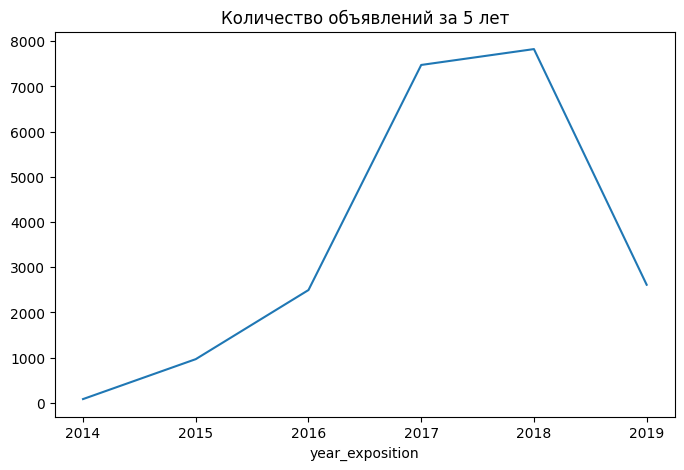

In [439]:
df.groupby('year_exposition').last_price.count().plot(figsize=(8,5))
plt.title('Количество объявлений за 5 лет')
plt.show()

C 2014 года средняя цена за квартиру падала с 7.3 млн рублей до 4.3 млн рублей в 2016, затем начала расти до 4.9 млн в 2019 году. Это связано прежде всего с увеличением количества объявлений до 2018 года, а также с уменьшением медианы общей площади, от которой так зависит цена квартиры. С учетом появления объявлений с меньшей площадью и следовательно меньшей ценой, а также с учетом "разводнения" новым количеством объявлений. Медианная цена квартиры упала, хотя рынок недвижимости за этот период рос

#### 10 самых самых

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [440]:
top_10_meters = (
    df.pivot_table(index='locality_name', values='meter_price',
               aggfunc=['count', 'mean'])
    .sort_values(by=(('count', 'meter_price')), ascending=False).head(10)
)
top_10_meters

,count,mean
,meter_price,meter_price
locality_name,,
Санкт-Петербург,14045,107119.623949
Мурино,492,86083.634593
Кудрово,462,95212.263788
Шушары,434,78687.904470
Всеволожск,375,67075.388053
Пушкин,342,101045.464094
Колпино,333,75380.806967
Гатчина,271,68882.901956


В списке выше приведены наиболее популярные места. Самая высокая цена квадратного метра соответсвует самому популярному месту - Санкт Петербургу 13281 квартиры. Цена кв метра в Питере 106 996  рублей, далее идет Пушкин 100 731 рубей за кв метр. Мурино как второе по популярности место 543 квартиры имеет лишь 86 328 рублей. Выборг как менее популярное место из 10-ки (194 квартир) имеет также и самую низкую цену в 58 842 рублей за кв метр

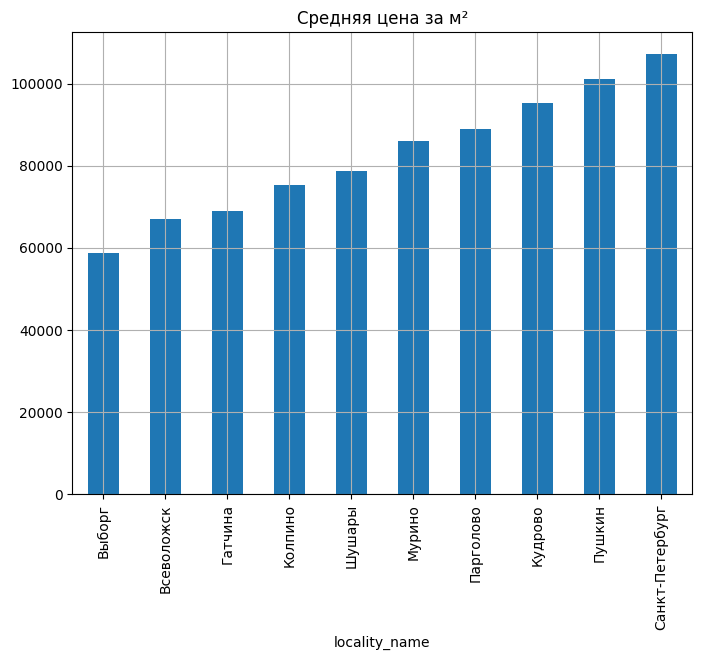

In [441]:
top_10_meters[('mean','meter_price')].sort_values().plot(kind='bar', grid=True, figsize=(8, 6))

plt.title('Средняя цена за м²')
plt.show()

In [442]:
price_center = (
    df.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='city_Centers_nearest_km',
                 values='last_price', aggfunc='mean')
)
price_center

,last_price
city_Centers_nearest_km,
0.0,9.248333e+06
1.0,9.308942e+06
2.0,8.978194e+06
3.0,8.166145e+06
4.0,8.567489e+06
5.0,8.390005e+06
6.0,7.826453e+06
7.0,7.181264e+06
8.0,7.141075e+06


В таблице наглядно видно, что при уменьшении расстояния квартиры от центра, также растет и цена объекта. Посмотрим эти изменения на графике

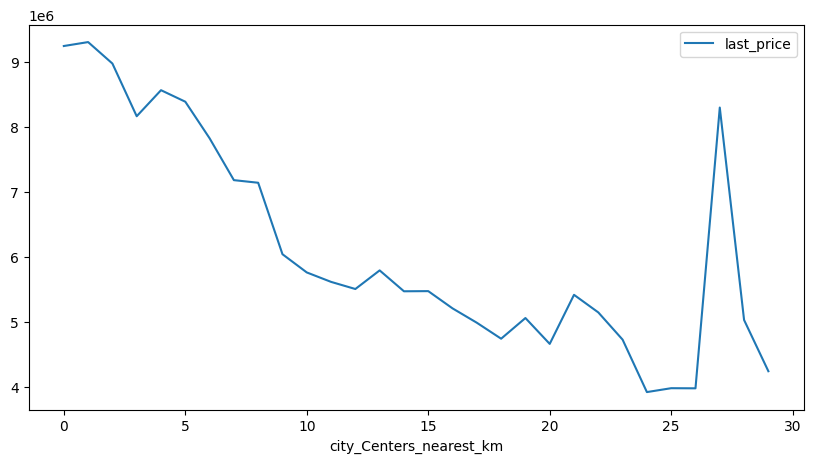

In [443]:
price_center.plot(figsize=(10,5))
plt.show()

На графике видно, что при удалении от центра цена стремительно падает в районе 4 км от центра и затем постепенно снижается. Видны некоторые всплески цены в районе 5 км и 27 км от центра. Скорее всего это квартиры либо с большей площадью, либо с дорогой отделкой 

In [444]:
df.loc[(df['locality_name'] == "Санкт-Петербург") & (df['city_Centers_nearest_km'] == 27)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_Centers_nearest_km,meter_price,weekday_exposition,month_exposition,year_exposition,floor_name
665,13,14350000,74.0,2017-11-28,2,2.6,5.0,30.0,3,False,...,1496.0,0.0,NaN,128.0,27.0,193918.92,1,11,2017,другой
5448,6,2250000,32.0,2018-02-27,1,2.5,2.0,16.5,2,False,...,NaN,0.0,NaN,178.0,27.0,70312.50,1,2,2018,последний


Выброс на 27 километре вызван скорее всего элитной недвижимостью цена которой 14 млн

In [445]:
df.loc[(df['locality_name'] == "Санкт-Петербург") & (df['city_Centers_nearest_km'] == 3)].floor_name.value_counts()


floor_name
другой       162
последний     63
первый        48
Name: count, dtype: int64

In [446]:
df.loc[(df['locality_name'] == "Санкт-Петербург") & (df['city_Centers_nearest_km'] == 5)].floor_name.value_counts()

floor_name
другой       489
последний     93
первый        70
Name: count, dtype: int64

Последний этаж занимает примерно 22% на 3 километре, а на 5 километре 14%, скорее всего с этим и связан пик и провал в центре

### Jбщий вывод

Целью работы, являлся анализ данных о недвижимости. 
Из данного анализа были получены следующие выводы

Ожидаемое время продажи объекта недвижимости - от 44 до 190 день
Наиболее быстрые продажи меньше 44 дней, наиболее долгие дольше 190 дней

Наибольшее влияние на стоимость квартиры оказывает её площадь, коэффициент корреляции 0,74. Также на стоимость квартиры влияет и количество комнат, площадь кухни и жилая площадь. На стоимость квартиры также влияет расстояние до центра города. Чем ближе квартира располагается к центру, тем выше стоимость квартиры.

Также составим представление о "типичной" квартире из выборки: стоимость около 3.4 млн.руб, квартира с 1-2 комнатами, общей площадью около 43 кв м и высотой потолков 2.65 м, в 5 или 9 этажном здании, на 1-ом по 5 этажах, площадью кухни около 5.5 кв м, расположенной на удалении от центра на расстоянии 13 км, от аэропорта на расстоянии 26 км, до ближайшего парка около 456 метров.

Из составленной выборки самых популярных мест по объявлениям известно:
Самая высокая средняя стоимость квадратного метра и большее число объявлений в Санкт-Петербурге - 106 996 руб кв м.
Самая низкая средняя стоимость квадратного метра и меньше всего объявлений в Выборге - 58 842 руб кв м.

С 2014 года медианная цена на квартиру упала, это связано с увеличеним количества объявлений, а также уменьшения медианной общей площади, хотя сам рынок недвижимости за это время рос

В  данных о времени продажи квартиры присутсвуют 2 моды, которые могли быть вызваны, принудительным закрытием большого количества объявлений в этот день, либо работой ботов на рынке недвижимости, которые с переодичностью обновляют свои предложения

В дальнейшем иследовании стоит обратить внимание на сегмент "элитных" квартир, которые явно выделяются своими параметрами и расцениваются как вбросы, хотя это может быть просто особенность данной квартиры

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [X]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [X]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [X]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [X]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [X]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [X]  На каждом этапе сделаны промежуточные выводы.
- [X]  В конце проекта сделан общий вывод.